<center><span style="color:#606c38;font-weight:700;font-size:15px;">

# Political Tweet and Bot Classifier - Turkish Politics
</span></center>
<center><span style="color:#AE2012;font-weight:700;font-size:15px;">
</span></center>

<center><span style="color:#023047;font-weight:700;font-size:15px;">

</span></center>



<center><span style="color:#606c38;font-weight:700;font-size:15px;">
Description
    </span></center>

<span><center> The present project aims to address two pressing issues in the context of Turkish Twitter: the proliferation of political content and the prevalence of bot accounts. Utilizing advanced machine learning techniques, the project seeks to classify political tweets and distinguish between genuine user accounts and bots. The project is being undertaken as part of the Machine Learning course offered by Dr. Onur Varol at Sabancı University, with the ultimate goal of contributing to a deeper understanding of these issues and their impact on online discourse in Turkey.

In [ ]:
from datetime import datetime as dt
from collections import Counter
import os, sys, glob
import pandas as pd
import numpy as np
import random
import gzip  
import tqdm
import json

pd.set_option("display.max_columns", None)

from matplotlib import pyplot as plt
from IPython import display
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline
%load_ext autoreload
%autoreload 2


<center><span style="color:#606c38;font-weight:700;font-size:15px;">
Feature Extraction
    </span></center>

Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

This section shows how to create a dataframe over the Twitter metadata using the created features. You can review the data generated as a result of this section in the GitHub repository and use it in your studies. Also, if you have a raw data set and want to use the features we extracted, you can upload your metadata and get the data.

## 1.1. Political Tweet Detection


### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [ ]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = "None"

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [ ]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [ ]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [ ]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [ ]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [ ]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [ ]:
def check_political_ent(text):
    # the list below can be modified and some new names may be added (or removed). Following usernames are the politicians in Turkey.
    list_of_entities = ['RTErdogan', 'BY', 'NumanKurtulmus', 'Hayati_Yazici', 'erkankandemir',         'aliihsanyavuz54', 
'avhamzadag', 'efkanala', 'jsarieroglu', 'mehmetozhaseki',         'nurettincanikli', 'AvOzlemZengin', 'leylasahinusta', 
'vedatdemiroz', 'CK_Samsun',         'mustafasenbd', 'DrOmerileri', 'omerrcelik', '_fatihsahin', 'aysekesir', 
'eyupkadirinan',         'kilicdarogluk', 'ahmetakin', 'ali_oztunc', 'bkusoglu', 'bulenttezcanchp', 'faikoztrak',         
'FethiAcikel', 'gamzeilgezdi', 'GokceGokcen_', 'GulizarBicer', 'lalekarabiyik',         'muharremerkek17', 'oguzksalici', 
'onursaladiguzel', 'selinsayekboke', 'seyit_torun',         'veliagbaba', 'yukseltaskinn', 'alibabacan', 'birolaydemir15', 
'yaseminbilgel1', 'bdalgin',         'emin_ekmen', 'mustafaergen_', 'erginsadullah', 'elifesendeva', 'helunfirat', 
'hasankaraltr',        'c_karlitekin', 'sanemoktar', 'hatipoglupaysun', 'rizvanogluevrim', 'avidrissahin',         
'dogasanlioglu', 'mustafaucak07', 'nazlisedavural', 'myeneroglu', 'medeniylmz',         'Ahmet_Davutoglu', 'mnedimyamali', 
'SelimTemurci', 'AyhanSeferUSTUN', 'dogandemir41',         'FeridunBilgin64', 'selcukozdag', 'abdullahbasci', 'kerimrota', 
'mustafamente', 'SerapProf',        'AliPulcu', 'umityardim1961', 'SemaSilkin', 'Hbb_Ciftcioglu', 'BMustafaGozel',         
'feramuzustun', 'torunkani', 'serkanozcan1', 'hdpdemirtas', 'figenyuksekdag', 'pervinbuldan',         'mithatsancarr', 
'ayseacar_b', 'av_ebrugunay', 'Feleknasuca', 'GaroPaylan', 'SaruhanOluc',         'ilknur_Birol', 'GuleryuzMahfuz', 
'meraldanis', 'musaproglu', 'sonmeznaci', 'salimkaplanhdp',        'drsametmenguc', 'sultanozcan38', 'saziyekose59', 
'TayipTemel', 'tuncerbakirhan',         'UmutDede16', 'velisacilik', 'YunusPARIM', 'meral_aksener', 'korayaydintr', 
'UGUR__POYRAZ',         'UmitDikbayir', 'BBahadirErdem', 'senolsunat', 'Ahmet_Erozan', 'ridvanuz17',         'SalimEnsarioglu', 
'MetinErgun48', 'ProfBilgeYilmaz', 'avtolgaakalin', 'UmitOzlale',         'SevincAtabay', 'avunzileyuksel', 'Akburak', 
'vekilince', 'dbdevletbahceli',         'E_SemihYalcin', 'yildizfeti', 'mkalayci42', 'ifarukaksu', 'ismailozdemirrr',         
'KarakayaMevlut', 'kamilaydinmhp', 'UlviYonter', 'sadirdurmaz', 'drpelinyilik',         'yasaryldrmmhp', 'buyukataman', 
'prfdrfilizkilic', 'tmrosmanagaoglu', 'bbbozarslan',        'umitozdag', 'herkesicinchp', 'adem__taskaya', 'alidincercolak', 
'sevdagultuncer', 'bartusoral', 'ayhanturkz',        'cezmi_polat', 'tugrulk_zaferp', 'draslanyaman', 'feridunyildiz', 
'BayirFikret', 'AyanGurol',        'ismail_turk55', 'KocakTukenmez', 'lutfusahsuvar', 'muratozgur2001', 
'kaptmustafacan',         'sagaltun', 'sedattimur161', 'sevdaozbk', 'seyityucel06', 'TCKayalak', 'ugurbaturr',         
'06melihgokcek', 'meral_aksener', 'osmannnurika', 'akaraismailoglu', 'varank',         'fahrettinaltun', 'deryayanikashb', 
'ayyildirim1', 'RTErdogan', 'mansuryavas06',         'ekrem_imamoglu', 'fuatoktay', 'FatmaSahin', 'drfahrettinkoca', 
'ikalin1',         'Canan_Kaftanci', 'tuncsoyer', 'senerabdullatif', 'korayaydintr', 'ilhankesici',         'samilayrim', 
'AhatAndican', 'EToprakCHP', 'Dr_Demircan', 'bedriyasartr',         'kemalcelik007', 'celal_adan', 'ihaliloral', 'Mbekaroglu', 
'cenginyurt52',         'dbdevletbahceli', 'CulhaMetanet', 'MetinErgun48', 'nurettincanikli',         'kilicdarogluk', 
'Hayati_Yazici', 'enginaltaychp', 'yasartuzun06', 'Akif_Hamzacebi',         'profdrhalukkoc', 'recepozel32', 'zulfudemirbag23', 
'BattalFetani', 'Bayramburdur',         'polatturkmen67', 'turan_haci', 'DrMehdiEker', 'ramazancan0071', 
'FeyziBerdibek1',         'ahmet_uzer27', 'mustafaatas', 'fahricakir81', 'MevlutCavusoglu', 'bybekirbozdag', 'BY',         
'ismailbilen45', 'Vahit_Kiler', 'oerdem42', 'mustafaelitas', 'DrRecepAkdag',         'HakkiKoylu37', 'yilmaz_ismet58', 
'TugrulTurkes', 'sdbilgic32', 'TekinBingolCHP',         'tasar_cemal', 'senolsunat', 'faikoztrak', 'muharremvarli01', 
'lutfielvan', 'buyukataman',         'erkanakcay45', 'MKalayci42', 'fkurtulan33', 'PervinBuldan', 'mehmeterdogan27', 
'fikriisik',         'yilmaztunc', 'behiccelik', 'VeyselEroglu', 'cumhurunal7806', 'IlknurInceoz', '_cevdetyilmaz',         
'AhmetAYDIN_02', 'oznurcalik', 'canankalsin', 'alev_dedegil', 'ahmetsalihdal', 'ackilic76',         'LutfuTurkkan', 
'ekremcelebi4', 'nacibostanci', 'halilozcan63', 'haydarakar',         'drorhanatalay56', 'Y_Akdogan', 'tanjuozcanchp', 
'goklevent', 'yunuskilic36', 'ahmetarslan36',         'emrullahisler', 'avyusufbaser', 'bkusoglu', 'gulaysamanci42', 
'E_SemihYalcin',         'Ziverozdemir', 'bulenttezcanchp', 'HBTurkoglu', 'aykuterdogdu', 'fehmikupcu14',         
'vedatdemiroz', 'SerminBalik23', 'nejatkocer', 'Mtanal', 'deryabakbak27', 'ismailgunes64',         'AliSahin501', 
'turanbulent', 'mehmedmus', 'TCAytunCiray', 'mehmetaltay64', 'enginozkoc',         'mdogankubat', 'AvTufanKose', '_fatihsahin', 
'aliihsanyavuz54', 'SIRIN_UNAL', 'gurseltekin34',         'CandanYceer', 'Hakan_cavusoglu', 'OA_Bak', 'MSErdinc', 
'sadirdurmaz', 'veliagbaba',         'mahirunal', 'Belmasatir', 'volkan_bozkir', 'avhamzadag', 'erolkaya_ist', 
'OsmanBoyraz',         'beratconkar', 'osman_oren', 'MustafaSentop', 'MSTanrikulu', 'UgurBayraktutan',         'tulaykaynarca', 
'uguraydemir45', 'eczozgurozel', 'eronat_oya', 'ilyasseker41',         'mvitamer', 'ismetUcma', 'NumanKurtulmus', 'umitozdag', 
'drrecepseker',         'DurmusYillmaz', 'AvUnaldemirtas', 'bkaradeniz57', 'drmehmet_goker',         'abdurrahmanbask', 
'CetinOsmanBudak', 'muratemirchp', 'kamilaydinmhp', 'ahhakverdi',         'seferaycan', 'avaliozkaya', 'mdurmusoglu', 
'avmetincelik', 'ozkan_yalim', 'leylasahinusta',         'ZiyaAltunyaldiz', 'av_ishakgazel', 'BaybaturMurat', 'tcbuyuksehir', 
'_ibrahimaydemir', 'kulmustafa77_ac',         'muhammetbalta61', 'adnangunnar', 'suleymansoylu', 'VecdiGundogdu', 
'ali_ihsanarslan',         'Av_Burcu03', 'Seyit_TORUN', 'drmadiguzel', 'erdinbircan', 'agral_abdullah', 'haozdemir',         
'uncuoglurecep', 'ZTaskesenlioglu', 'halisdalkilic', 'ImamTascier', 'haliletyemez',         'DrRidvanTuran', 'okangaytanciogl', 
'aysekesir', 'saffetsancakli', 'KarakayaMevlut',         'TurabiKayan', 'GulizarBicer', 'AvHalilFirat', 'myeneroglu', 
'ChpNihatYesil', 'arzuerdemDB',        'utkucakirozer', 'ahmetakin', 'ifarukaksu', 'Emine_Gozgec16', 'selvacam', 
'abdulhamitgul',         'MustafaYel59', 'aefakibaba', 'EnisBerberoglu1', 'DrCetinArik', 'tahsintarhan',         
'bakisimsekmhp', 'fatmakaplan', 'alikenanoglu', 'erkankandemir', 'ayhanbilgen',         'akbasogluemin', 'NevzatCeylan06', 
'HdpGaydali', 'hisyarozsoy', 'jsarieroglu',         'UlviYonter', 'selinsayekboke', 'mithatsancarr', 'SezaiTemelli', 
'oguzksalici',         'ZeynelEmre_', 'serkantopalchp', 'AvOzlemZengin', 'dilan_dirayet', 'berdan_ozturk',         
'ayseacar_b', 'onlu_alican', 'Feleknasuca', 'sezerkatirciogl', 'MuharremErkek17',         'ATuncayOzkan', 'HudaKaya777', 
'nimetullah__e', 'kazimarslan20', 'tacettinbayir',         'FuatKoktas55', 'nurhayataltaca', 'mvhuseyinyildiz', 
'KemalZeybek55', 'ismailok_',         'eminsimsekmus', 'Mustafa_CHP', 'ozcanpurcu', 'lalekarabiyik', 'togrularya', 
'erkanecz',         'CK_Samsun', 'bulenttufenkci', 'LeylaGuvenkcd', 'meraldanis', 'FilizKer', 'GaroPaylan',         
'orhansaribalchp', 'kamilsindir', 'HuseyinYayman', 'onursaladiguzel', 'metinbulut23',         'gamzeilgezdi', '55erhanusta', 
'draliseker', 'mehmetozhaseki', 'avmustafakose', 'ABabuscu',         'markaresayan', 'RavzaKavakci', 'MAkifYilmaz42', 
'Selami__Altinok', 'AhmetSCeylan',         'cihanpektas1', 'cengizaydogdu_', 'HaberalErkan', 'osmanakgul29', 
'celalettingvnc',         'dr_sozdemir', 'serapyahsiyasar', 'iekarayel', 'NergisAtci', 'erguntasci52', 'metingunordu',         
'AtillaSertell', 'av_ihalilyildiz', 'malicevheri', 'fethigurer', 'hasanturantr',         'sorgunahmet', 'CHPMuratBakan', 
'scakir20',  'cemil_yaman', '07ibrahimaydin', 'Tamer_Dagli',         'NazimMavis', 'Hilmi_Dulger79',  'ozturkyilmazYP', 
'ahmettan43',         'haciozkan33', 'MAtillaKaya', 'AvSerkanBayram',         'mvcemalozturk', 'AvSabriOzturk', 
'ahmethamdicamli', 'atayuslu', 'sahin_tin', 'avcahitozkan',        'AvOrhanKIRCALI', 'kadimdurmaz', 'gurselerol62', 
'alicumhurtaskin', 'yusufbeyazit60',         'aydinmsavas', 'harun_karacan', 'EmineNurGunay', 'mufitaydin16', 
'ebubekirbal_',         'SMinsolmaz', 'bediaozgokce', 'imranmkilic2023', 'ceydabc47', 'corasalih', 'drbetulsayan',         
'osmanmesten16', 'scivitcioglu', 'CilezHasan', 'akadirkaraduman', 'SermetAtay',         'ArkazHayati', 'drtasdogan', 
'muhammedavci53', 'mhpesinkara', 'mlkarahocagil',         'fahrettinyokus', 'yclblt06', 'avzeynepgul', 'hakansidali', 
'Avkthalilozturk',         'mnsazak', 'faruk_sariaslan', 'ahmetozyurekmhp', 'mutlaydemir', 'adil_celik10',         
'yavuzsubasi', 'belginuygur10', 'MustafaCanbey', 'gulenderacanal', 'a_kabukcuoglu',         'dryukselozkan', 'jalenursullu', 
'ali_oztunc', 'rizgin__birlik', 'mustafa_destici',         'gamzetascier', 'yildirimkaya40', 'avtutdere', 'drmetinilhan40', 
'yasaryldrmmhp',         'onalahmet71', 'mvkadiraydin', 'ozboyaciselman', 'cengizdmrky47', 'seyhmusdincel47',         
'toprak_av', 'yakuptas02', 'ay_altintas', 'nevintaslicay', 'habibeocal46', 'mcihatsezal',         'avahmetozdemir', 
'kayaismail80', 'bahaunluchp', 'abuyukgumus', 'irfankaplanchp',         'ozcanozel_', 'prhasankalyoncu', 'mehmettaytakmhp', 
'mhrpolat', 'fikretsahin10',         'yzyilmaz55', 'avyurdunuseven', 'hasanbaltacichp', 'drservetunsal', 
'e_erkanbalta',         'barisaydin06', 'dr_h_avniaksoy', 'eyupozsoymv', 'senelyediyildiz', '24burhancakir',         
'suleymankrmn', 'cengiz_gokcel', 'oyaersoy', 'tatliogluismail', 'tahir_akyurek',         'gokanzeybekchp', 'OzgurKarabatCHP', 
'alimahir', 'ozturkdenizli', 'nacicinisli',         'mguzelmansurchp', 'tokdemirismet', 'ErolKAVUNCU', 'avoguzhankaya', 
'm_levent_bulbul',         'mbulentkaratas', 'ilhamiozcanaygn', 'mucahitarinc', 'alpayozalan35', 'kanibekochp',         
'ednanarslanchp', 'fazilkasap', 'sevdaerdan', 'avSelmanEser', 'ahmetcolakoglu0',         'satiroglu2018', 'hamdiucar67', 
'UmitDikbayir', 'mustafademir', 'ahmetcelikycag',         'yukselmuslum27', 'iffetpolat', 'msaitkirazoglu', 'esarea', 
'kaplanenez', 'bakiersoymhp',         'mugokgoz32', 'h_nuhoglu', 'orhanyegin', 'ramazannkasli', 'AAsumanErdogan',         
'SirakayaZafer', 'mdervisoglutr', 'yildizfeti', 'azizaydinlikchp', 'osmangulacartr',         'selimyagci11', 'yukselmkilinc', 
'ProfDrFiliz', 'zaferisik016', 'yasarkirkpinarr',         'cccemalcetin', 'abdulkadirozl', 'hsanverdi', 'sabahatozgursoy', 
'avukatayhanerel',         'yavuzagiraliog', 'avmustafaarslan', 'baharayvazoglu', 'fatmaaksal', 'mustafaesgin016',         
'HVahapoglu', 'atillaodunc16', 'hasan_subasi', 'yasinugurmv', 'abdullahdogru01',         'gergerliogluof', 'mvyavuzergun', 
'ceydaerenler', 'selimgultekn51', 'semihaekinci58',         'feridun_bahsi', 'refik_ozen16', 'h_ahmet_kilic', 
'vildanylmzgurel', 'mhpyasarkaradag', 'ikoncuk', 'aysesibelersoy', 'avantmen33', 'yunusemrechp', 'suzansahin1881', 
'sahmetsahmet', 'ahmeterbas43', 'dursunatas38', 'rafet_zeybek', 'selcukmizrakli', 'kemalpekoz', 'tmrosmanagaoglu', 
'perodundar', 'AyseSurucuUrfa', 'yavuzyilmazd', 'AvTuranAydogan', 'TulayHatim', 'ArvasAbdulahat', 'unalcevikoz', 
'orhancakirlar22', 'Sdk56hdp', 'ahmetakayurfa', 'ahmetcakir44', 'hkahtal', 'avsbulbul', 'apolatduzgun',         'omerrocalan', 
'zyildiz_', 'zeynelozenhdp', 'dilsatcanbaz', 'zuleyhagulum', 'TayipTemel', 'aysubankoglu', 'ensaraytekin10', 'Hasanozgunes1', 
'av_ebrugunay', 'DrHabip',         'nusrettin_macin', 'rumeysakadak', 'umitbeyaz34', 'ar_aydn', 'cesuraylin', 'ahmetkayachp', 
'murselalban', 'mvsuatozcan', 'ntigli28', 'MehmetYavuzDem3', 'ahmet_erozan',         'AyhanBarut01', 'husretdinc30', 
'eczumityilmaz', 'ismailozdemirrr', 'nuran_imir', 'avhuseyinkacmaz', 'orhanssumer', 'IpekyuzNecdet', 'tuma_celik', 
'polatsaroglu', 'ethemsedef', 'RemziyeTosunHDP', 'semraguzelhdp', 'MuratCepniHDP', 'serpilkemalbay', 'eczburhan', 
'avmensurisik', 'emecangulizar', 'basevirgenbekir', 'teomansancar20', 'avbakirlioglu', 'aydinasezgin', 'lutfikasikci', 
'Muazzezorhn', 'mzyensevkin', 'ckoncagul', 'neslihancioglu', 'glstnkocyigit', 'chpatakanunver', 'ahmetzenbilci', 'a_yildiz_', 
'Nilgun_OK', 'sgirgin48tbmm', 'bedriserterchp', 'muratsarisac', 'erkbas', 'm_farisogullari', 'celebimehmeta', 'dersimdag21', 
'DrSaitDede', 'sevincoskun_', 'metinyavuz009', 'bekirkuvveterim', 'abdullahkochdp', 'mv_cavitari', 'rizaposaci', 'necipnasir', 
'irfankartal_65', 'avabdullahguler', 'eminezeybek_mv', 'yucelmenekse50', 'ibrahimkaboglu', 'cigdematabek', 'serakadigil', 
'melihaakyol77', 'Cbekle', 'OlcayKilavuz', 'vekilyilmazkaya', 'musaproglu', 'DpGultekinUysal', 'skaplankivircik', 
'ozgurceylanchp', 'zulfutolgagar', 'yeldagokcan', 'ozkanmehmetali', 'iozyavuz1963', 'cihangirislam', 'jiskenderoglu', 
'aydinozer07', 'tubavuralcokal', 'barisatay', 'ErolKat', 'averdalaydemir', 'burakerbaychp', 'alikevenyozgat', 'ulasskarasu', 
'mhabibsoluk', 'efkanala', 'uzancc', 'T_Karamollaoglu', 'LeventTuzel', 'AbdullahZeydan', 'A_Boynukalin', 'AbdurrahmanOz09', 
'akgulkadir66', 'ademyesildal', 'AdnanBoynukara', 'adnanyilmaz_', 'cirkinoglu', 'AhmetMisbah', 'ahmetgundogdu01', 
'akenantanrikulu', 'ahmet__yurdakul', 'ahmetyildirihdp', 'ahmet_iyimaya', 'aknustundag48', 'alev_dedegil', 'AliAkyildiz58', 
'AliAtalan68', 'AydinliogluA', 'AliErcoskun', 'ahhakverdi', 'AliHaydarKonca', 'AliUzunirmak', 'aliozmersin', 'chpaliozcan', 
'aliinci54', 'AlimISIK', 'Adursun15', 'alp_kavaklioglu', 'AltanTan1958', 'asiyekolcakhdp', 'aslansavasan', 'AtilaKaya_MHP', 
'aycanirmez', 'auslupehlivan01', '_aydinunal', 'ayhanbilgen', 'ayhanyilmaz06', 'AylinNazliaka', 'aytugatici', 'dtaysedogan', 
'GBilgehan', 'aysesula', 'aysenurlslam', 'bakisimsekmhp', 'bkaradeniz57', 'barisyarkadas', 'yildirimbehcet', 'BKaraburun', 
'BihlunTamaylgil', 'UcarBilal20', 'CHPbirolertem', 'avburcucelik', 'Burhan_Kayaturk', 'BulentBelen59', 'bulenttufenkci', 
'bybektasoglu', 'CHPBulentOz', 'cahitbagci', 'CananCCelik', 'CDaggez', 'celaldgn2727', 'celilgocer', 'cemalokanyuksel', 
'cemalettin_kafl', 'torunkani', 'cemil_seboy', 'CengizTokmak', 'ceyhunirgil', 'coskuncakir60', 'dengirmir1', 'chpdevrimkok', 
'_DidemEngin', 'OcalanDilek', 'dilan_dirayet', 'Aliskaya',         'dfikrisaglar', 'yalcin0634', 'drdursuncicek', 'edibberk', 
'edibe_sahin', 'profdrihsanoglu', 'erdemekrem', 'Avturkmen', 'EminHalukAyhan', 'Cinremin', 'profdrbeyzaustn', 'EmreKoprulu', 
'eniseguneyli', 'enverfehmioglu', 'erdal_atas1', 'erdinbircan', 'erdoganozegenn', 'ErdoganOzyalcin', 'erenerdemnet', 
'ErolDora', 'ertanaydin', 'ekurkcuHDP', 'drsoysal', 'etorhan09', 'ProfEthemTolga', 'oguz_tor', 'caturgil', 'Dr_Faruk_Ozlu', 
'AvFatmaBenli', 'fdemetsari', 'fatmakaplan', 'hotar_nukhet', 'FaysalSaryldz', 'FerhatEncu', 'FevaiARSLAN', 'f_kiyiklik', 
'FilizKer', 'GayeUsluer', 'gokcenenc07', 'gulayyedekci', 'yildirimgulser', 'gurseltekin34', 'haozdemir', 'halilerdemir17', 
'halilurun', 'halukpeksen', 'hamdi_irmak', 'hamidesrc', 'HarunKaraca1', 'hasanbasrikurt', 'haskokten', 'drhasansert', 
'hasanozyercom', 'haticeseviptekn', 'havva_calis38',         'hayatitekin55', 'haydaraliyildiz', 'AYARHikmet', 'avhilmibilgin', 
'hilmiyarayici', 'huseyinburge', 'HuseyinEdis', 'huseyinnfiliz', 'hsyk35', 'HuseyinSamani', 'huseyincamak', 'ozbakirakparti', 
'HusniyeErdogan', 'KadirKocdemir', 'MamosteKadri', 'drkadrikaraoglu', 'KemalTekden', 'K_Aydin', 'KSurekli', 'znaz_k', 
'BirlikLeyla', 'leylazanainfo', 'LezginnBotan', 'ilksen_kurt19', 'poyrazlimahmut', 'MahmutSamiMALLI', 'Mazhar_Bagli', 
'MazlumNurlu', 'Akif_Hamzacebi', 'HemmedAliAslan', 'MehmetAlgan_', 'mbabaoglu', 'meminadiyaman_', 'mehmeteminilhan', 
'eminsimsekmus', 'mfatihatay', 'gokdagantep', 'mehmetgunal07', 'MetinerBasin', 'MuezzinogluDR', 'mehmetparsak', 
'mehmetsadikatay', 'mehmettumnet', 'mehmetucum', 'mehmetdilipak', 'mehmetvarolmhp', 'MehmetYukselMlv', 'mehmetonturk', 
'drilkercitil', 'DrMehmetSeker', 'mehmetesk1974', 'MSErdinc', 'MelikeBasmac', 'mkulunk', 'mlbaydar', 'avmetincelik', 
'MevlutDudu', 'mizginirgathdp', 'yalcinkayariza', 'kizilkayamuhsn', 'Murat_Alparslan', 'mbasesgiolu37', 'muratemirchp', 
'AvMuratGokturk', 'muratkocmhp', 'musacam', 'm_akaydin', 'mustafabalbay', 'drmusbaloglu', 'mustafaerdem_06', 'MGGulsen', 
'HsnBozkurt', 'mustafamit58', 'mustafagultak', 'drsgonen', 'MustafaYun', 'Mustafa_DSMI', 'profmustafaisen', 'mustafashn44', 
'msnazli', 'muslumdogan59', 'naci_agbal', 'nacibostanci', 'namikhavutca', 'necatiyilmazank', 'necdetunuvar', 'Nesrinulema', 
'nevzatpalta', 'nihatakdagon', 'ChpNihatYesil', 'ZeybekciNihat', 'niyazinefikara', 'NureddinNebati', 'nurettin_demir', 
'nurttinyasar', 'nurhayataltaca', 'TCNuriOkutan', 'nurselaydogan58', 'nursel2023', 'oktayvural', 'oktaycanak52', 
'OktayOzturk_MHP', 'DuzgunOrhan', 'orhanerzurum28', 'KarasayarOrhan', 'OrhanMiroglu', 'baydemirosman', 'CanAnayasa', 
'okagankoksal', 'mvrecaiberber', 'recep_konuk', 'RemziOzgokce', 'remziyesivaci', 'ResatPetek', 'Akresitpolat79', 'ersoyruhi', 
'ruhsardemirel', 'ruveydegulseren', 'SaadetBecerekli', 'sadullahkisacik', 'Said_Yuce', 'DrSalihFirat', 'eskoca26', 
'salih_etinkaya', 'salimuslu__', 'seher_akcinar', 'selimdursun06', '_SelinaDogan', 'selmairmakhdp', 'semakirci', 
'profserpilbulDr', 'sevimsavaser', 'seyfettinyilmaz', 'SeyitAhmetGocer', 'Seydiamca', 'SezaiTemelli', 'Sibelyigitalp', 
'DrSuatOnal', 'suleymankrkmz38', 'sencerayata', 'SSadiBilgic', 'sirsureyya', 'TahaOzhan', 'dr_durmaz', 'tkucukcan', 
'tarkanakilli', 'taskinaktas65', 'TekinBingolCHP', 'topal_tevfik', 'turyildizbicer', 'TuranYALDIR', 'OkerTurgut', 'AlcelikDr', 
'TugbaHezer', 'TulaySelamoglu', 'uguraydemir45', 'ugur_isilak', 'vedatbayramtc', 'vedatbilgn', 'VeysiKaynak', 
'drvural_kavuncu', 'yaktay', 'YasarKarayel38', 'HDPozsokmenler', 'yusufhalacoglu', 'ytezcan33', 'ZTaskesenlioglu', 
'zekeriyabirkan', 'aygunzeki', 'AvBalkiz', 'zeynabelle', 'ZihniAcba', 'ziverzdemir72', 'ziyapir', 'Ziyaroni', 'profzuhaltopcu', 
'Zinonutumer', 'caglardemirell', 'oz_cilem', 'OmerSuhaAldan', 'OnderMatliBursa', 'AvUnaldemirtas', '_ibrahimaydemir', 
'ibrayhan', 'ikursattuna', 'ibrahimozdis01', 'idrisbaluken', 'idrisgulluce', 'ihsanozkes', 'ihsansener',         
'ilhancihaner', 'ilhankesici', 'irfanbakirchp', 'ismetsu16', 'israfilkisla', 'safakpavey', 'safak_ozanli', 'samiltayyar27', 
'Sebnem_kcklc', 'sefkatcetin', 'Semsettinemir', 'senalsarihanchp', 's_turpcu', 'SuayAlpay', 'akadiryuksel27', 'ademgeveri', 
'chpakifekici', 'alimtunc', 'Ataullahhamidi', 'AtillaSertell', 'GiderAyhan', 'azmiekinci34', 'BayramOzcelik15', 'koncabesime', 
'Atalay_Besir', 'BurhanKuzu', 'burhanettinuysl', 'CemilCicekTBMM', 'Cesimgokce', 'DenizDepboylu', 'bekirgizligider', 
'ejderacikkapi', 'farukcelikcomtr', 'SanverdiFevzi', 'dfikrisaglar', 'gulayyedekci', 'mhabibsoluk', 'avhalukipek', 
'yildirimhursit', 'NergisAtci', 'HusnuyeErdogan', 'KASIM_BOSTAN', 'mahmutkacar23', 'Mehmet__Akyurek', 'malicevheri', 
'MehmedAliSahin', 'MvMehmetdemir', 'mehmeterdem09', 'GalipEnsarioglu', 'mehmetahrazoglu', 'metinakgun59', 'MikailArslan40', 
'muratd37', 'mustafaelitas', 'm_ilicali', 'mserden', 'Murteza_Zengin', 'nadiryldrm_', 'NazimMavis', 'KalkanNecip', 
'nihat_ozturk', 'nurettinaras76', 'orhandeligoz25', 'rafet_sezen22', 'SaadetBecerekli', 'mvsamidedeoglu', 'vekilkarakelle', 
'SMinsolmaz', 'RamazanogluDr', 'skuyucuoglu33', 'dr_sozdemir', 'TahirOzturk23', 'ATuncayOzkan', 'TugbaHezer', 'YakupAkkayaCHP', 
'ysbeyribey', 'ZTaskesenlioglu', 'zeyidaslan', 'omerserdarcomtr', 'omerrunal', 'ozcanulupinar67', 'ibrahimmturhan2', 
'avismailaydin', 'bilenismail4513', 'ikahramanbv', 'dislisaban', 'sahapkavcioglu', 'sahin_tin', 'AbdurahimAksoy', 'A_Bilgic_', 
'mufityetkin63', 'ABurcinYereli', 'ahmetedip_ugur', '_ahmetergin_', 'afunsal02', 'IhsanMerdanoglu', 'alibabaoglan', 
'AliUfukYasar', 'arzukiliclar_', 'ayseezgi_y', 'baharsaygili', 'bdenizbagatur', 'Bsaslan', 'cetinerbilgehan', 'bunyaminunIu', 
'cnbrkdmrci', 'cemavsar44', 'ddkarakullukcu', 'EssumAslan', 'KuyumcuOya', 'FerayiOkmen', '_furkanaydogan', 'guldidempekuz', 
'glcnavsar', 'haldunhakci', 'nalbantogluben', 'ialperakalin', 'DonertasIbrahim', 'ibrahimgezer44', 'ihsangunaydin61', 
'ilkercelik_tr', 'KKosdere', 'KEsraAygun', 'kemalcangur', 'keremaltun65', 'KeremYavasca', 'mSamitopbas', 'MeltemGurler', 
'merve_molkeles', 'metin4020', 'metinkasikoglu', 'seyda_73', 'Musamalikyldrm2', 'Mustafanuriakbu', 'msatici_', 
'nazlisedavural', 'oguzhan', 'omgencal', 'ongun_ramiz', '_RojhatOlmez', 'sanemoktar', 'Sedatkadioglu25', 'ozsoyhalil38', 
'tugbatapsiz', 'avtunahanelmas', 'zeynepdereli', 'AlagzMehmet', 'TugbaDemirbag', 'meldatopyay', 'erdincorencik', 'kemalmert33', 
'hbaksener', 'Kursatdag25', 'incilaygezgin', 'erayerturk06', 'MustafaOzelden', 'Serdozturk', 'ugur_tarhan', 'mehmeteminozbey', 
'salimkbskl', 'EBulentKutlu', 'ddagasan', 'avfmelike', 'ilkimyuksel_', 'VedatCakiroglu', 'bekirs23', 'ibrahimtuzcu2', 
'neslihanrvana', 'ErpolatOzgur', 'Namikozturk_', 'sevvalckaya', 'omerturantv72', 'AGuzeldulger', 'teber_abdullah', 
'abdullahyesil63', 'akadirbaykay', 'adnandemir23', 'ahmedakcay', 'Ahmetcoktan1', 'ahmetmufitceng', 'aoguzkaraoglu', 
'profaliakmaz', 'yorukalipasa', 'DilmenAli', 'A_Kursad_Giray', 'Khaledkhoja', 'AvniErdemir', 'aydin_altac', 'aynuralgul', 
'sevimli_berrin', 'DrAyseGuney', 'OvundurAyse', 'bbberkan1', 'cancankesen', 'Cesimgokce', 'Cihanoztunc', 'cumaicten', 
'DinerTRKMEN3', 'diyaettinucar72', 'DoganKoruyucu_', 'ebekiryldrm', 'EnginKeskinel', 'avmeydan', 'esedatcakiroglu', 
'mahcupyanlink', 'fatihdkaya', 'aydinatasfatma', 'serefogluf', 'EsenerFerhat', 'fvzdnt', 'FidanStrate',         'GuzinnYildiz', 
'hmehmetkaratas0', 'kulak_halil', 'imamoglu', 'aksener', 'bay kemal', 'babacan', 'davutoglu', 'tcbestepe','halime_polat', 
'HamideMercan_', 'HHBOZOK06', 'hsbilir', 'HasanTaskintr', 'ibrahimmturhan2', 'isamesihsahin', 'izzettinkucuk', 
'kemalsisman_tr', 'arslanmfatih', 'mehmetkugutr', 'mehmetokcu_', 'silivrimetin', 'muammerkibarr', 'mstafacakmakci', 
'muharremodemis', 'muhsindemiroz', 'aratmusa', 'makarahangil', 'bahadirkurbano', 'drmusbaloglu', 'mbilici', 'ozturk_mustafa', 
'yesilyurt_', 'ergunnamik', 'nazmiirak', 'NihalOlcok', '_nihatizsiz', 'nuraysagiroglu', 'orhansucu_', 'StHaberAnaliz', 
'ofunal', 'PerihanTogay', 'gokaktasraziye', 'recepvarol73', 'RBekiroglu', 'sasasmaz', 'AynuralSalih', 'selahattinkymnn', 
'srnyildizozturk', 'yigitbulutt', 'SeyfettinBilen', 'senolgursan39', 'urfayeniden', 'dr_durmaz', 'tuncaydinc007', 'ufukkarcii', 
'vahdettinince', 'GelecekVeysi', 'Yasemin1974dk', 'yavuzdegirmenci', 'karadagyesim', 'yziyaozcan', 'Zekayidogan', 
'zeynepiscan3', 'ProfHakkiAkalin', 'Buraksvtr', 'SenbilinNEYAPTI', 'profahmetozalp', 'serkanufukakgun', 'yagizelver', 
'Gurbuz_Evren', 'asumanaliguven', 'meryemkalaMK', 'bhaciguzeller', 'avbestetuncel', 'guneyaykut21', 'profguzey', 
'muharremyildiz7', 'yusufsel010', 'orhansim', 'Eryildiz2013', 'ayberkyagiz', 'ElaldNejat', 'sertaysalman', 'ipekozkal', 
'sdincberk', 'SerhatGalip2', 'GayeUsluer', 'ufkundogan', 'MevlutDudu', 'EsberAtila', 'ErgunerSuleyman', 'ilhanduzyurek', 
'keremdonat', 'mahirbakan', 'alitunccan', 'oserkanileri', 'arbuyukuslu', 'GolgelerinN', 'DrOguzGiray', 'omerozdogan_06', 
'serefalbeniz', 'eke_ethem', 'SerkanYagsi', 'severrusen', 'nurdan_demirbag', 'Serpil_Memleket', 'kayhanyuregir', 
'drdursuncicek', 'aycasarikamisli', 'zbhasan', 'drok4835', 'TaylanhkmtGLHN', 'serkankucukkuru', 'Dr_SibelAraci', 
'kazancioglum'    ]
    
    list_of_entities = list(set(list_of_entities))
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [ ]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

#### 1.1.2.3. Number of total political keywords

In [ ]:
def check_political_keywords(text):
    # the list below can be modified and some new names may be added (or removed) the keywords are determined by looking at the most common words in the tweets posted in the Turkish political world.
    list_of_keywords = ['ziraat', 'öğretmen', 'bekliyor', 'devlet', 'engelli', 'bakanım', "reis",    'sosyal', 'genel ', 
                        ' genel', 'af ', 'vekilim', 'chp', ' sn', 'sn ' 'başkanım', '15', 'güvenli̇k', 'hak', "özlük",    
                        '3004', 'öğretmenlerin', 'kpss', 'taşeron', "kadro", "çalış" 'mağdur', 'vatan', 'türkiye', 'kemal', 'adalet',     
                        'oy ' 'çalışan', 'li̇sans', 'istiyoruz.', 'genelaf', 'millet', 'kamu', '🇹🇷', 'staj', 'khk',     
                        'ekrem', 'başkan', 'parti', 'ataması', 'asıl', 'özel', 'bekleyen', 'cumhurbaşkanımız',     
                        'tayyip', 'erdoğan', 'aday', 'kgm', 'i̇mamoğlu', '100.', 'feto', 'eyt', 'zam', 'enflasyon',   
                        'asgari', 'akp', 'chp' , 'mhp','hdp', 'tbmm', 'bay kemal', 'secim', 'pkk'   
                        'Recep Tayyip Erdoğan', 'Binali Yıldırım', 'Numan Kurtulmuş', 'Hayati Yazıcı', 
                        'Erkan Kandemir',     'Ali İhsan Yavuz', 'Hamza Dağ', 'Efkan Ala', 'Julide Sarıeroğlu',
                        'Mehmet Özhaseki',     'Nurettin Canikli', 'Özlem Zengin', 'Leyla Şahin Usta', 'Vedat Demiröz', 
                        'Çiğdem Karaaslan',     'Mustafa Şen', 'Ömer İleri', 'Ömer Çelik', 'Fatih Şahin', 'Ayşe Keşir', 
                        'Eyyüp Kadir İnan',     'Kemal Kılıçdaroğlu', 'Ahmet Akın', "3600", 'Ali Öztunç', 
                        'Bülent Kuşoğlu', 'Bülent Tezcan',     'Faik Öztrak', 'Fethi Açıkel', 'Gamze Akkuş İlgezdi', 
                        'Gökçe Gökçen', 'Gülizar Biçer Karaca',     'Lale Karabıyık', 'Muharrem Erkek', 
                        'Oğuz Kaan Salıcı', 'Onursal Adıgüzel', 'Selin Sayek Böke',     'Seyit Torun', 'Veli Ağbaba',
                        'Yüksel Taşkın', 'Ali Babacan', 'Birol Aydemir', 'Yasemin Bilgel', 'Burak Dalgın', 
                        'Mehmet Emin Ekmen', 'Mustafa Ergen', 'Sadullah Ergin', 'Elif Esen', 'Münevver Helün Fırat', 
                        'Hasan Karal', 'Candan Karlıtekin', 'Sanem Oktar', 'Aysun Hatipoğlu Potgieter', 
                        'Evrim Rızvanoğlu', 'İdris Şahin', 'Doğa Şanlıoğlu', 'Mustafa Uçak', 'Nazlı Seda Vural', 
                        'Mustafa Yeneroğlu', 'Medeni Yılmaz', 'Ahmet Davutoğlu', 'Mustafa Nedim Yamalı', 'Selim Temurci', 
                        'Ayhan Sefer Üstün', 'Doğan Demir', 'Feridun Bilgin', 'Selçuk Özdağ', 'Abdullah Başçı', 
                        'Kerim Rota', 'Mustafa Mente', 'Serap Yazıcı', 'Mehmet Ali Pulcu', 'Ümit Yardım', 
                        'Sema Silkin Ün', 'Habibe Çiftçioğlu', 'Mustafa Gözel', 'Feramuz Üstün', 'C. Kani Torun', 
                        'Serkan Özcan', 'Selahattin Demirtaş', 'Figen Yüksekdağ', 'Pervin Buldan', 'Mithat Sancar', 
                        'Ayşe Acar Başaran', 'Ebru Günay', 'Feleknas Uca', 'Garo Paylan', 'Hakkı Saruhan Oluç',
                        'İlknur Birol', 'Mahfuz Güleryüz', 'Meral Danış Beştaş', 'Musa Piroğlu', 'Naci Sönmez', 
                        'Salim Kaplan', 'Samet Mengüç', 'Sultan Özcan', 'Şaziye Köse', 'Tayip Temel', 'Tuncer Bakırhan',
                        'Ümit Dede', 'Veli Saçılık', 'Yunus Parım', 'Meral Akşener', 'Koray Aydın', 'Uğur Poyraz',
                        'Ümit Dikbayır', 'Bahadır Erdem', 'Şenol Sunat', 'Ahmet Kamil Erozan', 'Rıdvan Uz', 
                        'Mehmet Salim Ensarioğlu', 'Metin Ergün', 'Bilge Yılmaz', 'Mehmet Tolga Akalın', 
                        'Ümit Özlale', 'Sevinç Atabay', 'Ünzile Yüksel', 'Burak Akburak', 'Muharrem İnce', 
                        'Devlet Bahçeli', 'Edip Semih Yalçın', 'Fethi Yıldız', 'Mustafa Kalaycı', 'İsmail Faruk Aksu',
                        'İsmail Özdemir', 'Mevlüt Karakaya', 'Kamil Aydın', 'İzzet Ulvi Yönter', 'Sadir Durmaz',
                        'Pelin Yıkık', 'Yaşar Yıldırım', 'İsmet Büyükataman', 'Filiz Kılıç', 'Tamer Osmanağaoğlu',
                        'Bahadır Bumin Özarslan', 'Ümit Özdağ', 'Adem Taşkaya', 'Ali Dinçer Çolak', 'Sevda Gül Tunçer',
                        'Bartu Soral', 'Ayhan Türk', 'Cezmi Polat', 'Tuğrul Kihtir', 'Aslan Yaman', 'Feridun Yıldız',
                        'Fikret Bayır', 'Gürol Ayan', 'İsmail Türk', 'Koçak Tükenmez', 'Lütfü Şahsuvaroğlu', 
                        'Murat Yıldız', 'Mustafa Can', 'Salih Zeki Altun', 'Sedat Timur', 'Sevda Özbek', 'Seyit Yücel',
                        'Tuğrul Çağrı Kayalak', 'Uğur Batur', 'İbrahim Melih GÖKÇEK', 'Meral AKŞENER', 
                        'Osman Nuri KABAKTEPE', 'Adil KARAİSMAİLOĞLU', 'Mustafa VARANK', 'Fahrettin ALTUN', 
                        'Derya YANIK', 'Ahmet Yiğit YILDIRIM', 'Recep Tayyip ERDOĞAN', 'Mansur YAVAŞ', 'Ekrem İMAMOĞLU', 
                        'Fuat OKTAY', 'Fatma ŞAHİN', 'Fahrettin Koca', 'İbrahim Kalın', 'Canan Kaftancıoğlu', 
                        'Tunç Soyer', 'Deniz BAYKAL', 'Abdüllatif ŞENER', 'Koray AYDIN', 'İlhan KESİCİ', 'Şamil AYRIM', 
                        'Abdul Ahat ANDİCAN', 'Erdoğan TOPRAK', 'Ahmet DEMİRCAN', 'Bedri YAŞAR', 'Kemal ÇELİK', 
                        'Celal ADAN', 'İbrahim Halil ORAL', 'Mehmet BEKAROĞLU', 'Cemal ENGİNYURT', 'Devlet BAHÇELİ', 
                        'Mehmet Metanet ÇULHAOĞLU', 'Metin ERGUN', 'Nurettin CANİKLİ', 'Kemal KILIÇDAROĞLU', 
                        'Hayati YAZICI', 'Engin ALTAY', 'Yaşar TÜZÜN', 'Mehmet Akif HAMZAÇEBİ', 'Ahmet Haluk KOÇ', 
                        'Recep ÖZEL', 'Zülfü DEMİRBAĞ', 'Fetani BATTAL', 'Bayram ÖZÇELİK', 'Polat TÜRKMEN', 'Hacı TURAN',
                        'Mehmet Mehdi EKER', 'Ramazan CAN', 'Feyzi BERDİBEK', 'Ahmet UZER', 'Mustafa ATAŞ', 'Fahri ÇAKIR', 
                        'Mevlüt ÇAVUŞOĞLU', 'Bekir BOZDAĞ', 'Binali YILDIRIM', 'İsmail BİLEN', 'Vahit KİLER', 
                        'Orhan ERDEM', 'Taner YILDIZ', 'Mustafa ELİTAŞ', 'Recep AKDAĞ', 'Hakkı KÖYLÜ', 'İsmet YILMAZ',
                        'Yıldırım Tuğrul TÜRKEŞ', 'Süreyya Sadi BİLGİÇ', 'Tekin BİNGÖL', 'Cemal TAŞAR', 'Şenol SUNAT', 
                        'Faik ÖZTRAK', 'Muharrem VARLI', 'Lütfi ELVAN', 'İsmet BÜYÜKATAMAN', 'Erkan AKÇAY',
                        'Mustafa KALAYCI', 'Fatma KURTULAN', 'Pervin BULDAN', 'Mehmet ERDOĞAN', 'Fikri IŞIK', 
                        'Yılmaz TUNÇ', 'Behiç ÇELİK', 'Veysel EROĞLU', 'Cumhur ÜNAL', 'İlknur İNCEÖZ', 'Cevdet YILMAZ',
                        'Ahmet AYDIN', 'Öznur ÇALIK', 'Canan KALSIN', 'Alev DEDEGİL', 'Ahmet Salih DAL',
                        'Akif Çağatay KILIÇ', 'Lütfü TÜRKKAN', 'Ekrem ÇELEBİ', 'Mehmet Naci BOSTANCI', 
                        'Mehmet Kasım GÜLPINAR', 'Halil ÖZCAN', 'Haydar AKAR', 'Orhan ATALAY', 'Yalçın AKDOĞAN',
                        'Tanju ÖZCAN', 'Levent GÖK', 'Yunus KILIÇ', 'Ahmet ARSLAN', 'Emrullah İŞLER', 'Yusuf BAŞER',
                        'Bülent KUŞOĞLU', 'Gülay SAMANCI', 'Edip Semih YALÇIN', 'Ziver ÖZDEMİR', 'Bülent TEZCAN', 
                        'Hacı Bayram TÜRKOĞLU', 'Aykut ERDOĞDU', 'Fehmi KÜPÇÜ', 'Vedat DEMİRÖZ', 'Sermin BALIK',
                        'Abdullah Nejat KOÇER', 'Mahmut TANAL', 'Derya BAKBAK', 'İsmail GÜNEŞ', 'Ali ŞAHİN', 
                        'Bülent TURAN', 'Mehmet MUŞ', 'Aytun ÇIRAY', 'Mehmet ALTAY', 'Engin ÖZKOÇ', 'Mehmet Doğan KUBAT',
                        'Tufan KÖSE', 'Nabi AVCI', 'Fatih ŞAHİN', 'Ali İhsan YAVUZ', 'Şirin ÜNAL', 'Gürsel TEKİN', 
                        'Candan YÜCEER', 'Hakan ÇAVUŞOĞLU', 'Osman Aşkın BAK', 'Mehmet Şükrü ERDİNÇ', 'Sadir DURMAZ', 
                        'Veli AĞBABA', 'Mahir ÜNAL', 'Mihrimah Belma SATIR', 'Volkan BOZKIR', 'Hamza DAĞ', 'Erol KAYA',
                        'Osman BOYRAZ', 'Ahmet Berat ÇONKAR', 'Osman ÖREN', 'Mustafa ŞENTOP', 'Mustafa Sezgin TANRIKULU',
                        'Uğur BAYRAKTUTAN', 'Tülay KAYNARCA', 'Uğur AYDEMİR', 'Özgür ÖZEL', 'Oya ERONAT', 'İlyas ŞEKER',
                        'İsmail TAMER', 'İsmet UÇMA', 'Numan KURTULMUŞ', 'Ümit ÖZDAĞ', 'Recep ŞEKER', 'Durmuş YILMAZ', 
                        'Ünal DEMİRTAŞ', 'Barış KARADENİZ', 'Mehmet GÖKER', 'Abdurrahman BAŞKAN', 'Çetin Osman BUDAK', 
                        'Murat EMİR', 'Kamil AYDIN', 'Ali Haydar HAKVERDİ', 'Sefer AYCAN', 'Ali ÖZKAYA', 
                        'Mücahit DURMUŞOĞLU', 'Metin ÇELİK', 'Özkan YALIM', 'Leyla ŞAHİN USTA', 'Ziya ALTUNYALDIZ',
                        'İshak GAZEL', 'Murat BAYBATUR', 'İbrahim AYDEMİR', 'Mustafa AÇIKGÖZ', 'Muhammet BALTA',
                        'Adnan GÜNNAR', 'Süleyman SOYLU', 'Vecdi GÜNDOĞDU', 'Ali İhsan ARSLAN', 'Burcu KÖKSAL', 
                        'Seyit TORUN', 'Mustafa ADIGÜZEL', 'Berat ALBAYRAK', 'Erdin BİRCAN', 'Hakkı Saruhan OLUÇ', 
                        'Abdullah AĞRALI', 'Hacı Ahmet ÖZDEMİR', 'Recep UNCUOĞLU', 'Zehra TAŞKESENLİOĞLU BAN', 
                        'Halis DALKILIÇ', 'İmam TAŞÇIER', 'Halil ETYEMEZ', 'Rıdvan TURAN', 'Okan GAYTANCIOĞLU', 
                        'Ayşe KEŞİR', 'Saffet SANCAKLI', 'Mevlüt KARAKAYA', 'Türabi KAYAN', 'Gülizar BİÇER KARACA',
                        'İbrahim Halil FIRAT', 'Mustafa YENEROĞLU', 'Nihat YEŞİL', 'Arzu ERDEM', 'Utku ÇAKIRÖZER',
                        'Ahmet AKIN', 'Sena Nur ÇELİK', 'İsmail Faruk AKSU', 'Emine YAVUZ GÖZGEÇ', 'Lütfiye Selva ÇAM',
                        'Abdulhamit GÜL', 'Mustafa YEL', 'Ahmet Eşref FAKIBABA', 'Kadri Enis BERBEROĞLU', 'Çetin ARIK', 
                        'Tahsin TARHAN', 'Baki ŞİMŞEK', 'Fatma KAPLAN HÜRRİYET', 'Ali KENANOĞLU', 'Erkan KANDEMİR', 
                        'Ayhan BİLGEN', 'Muhammet Emin AKBAŞOĞLU', 'Nevzat CEYLAN', 'Mahmut Celadet GAYDALI', 
                        'Hişyar ÖZSOY', 'Jülide SARIEROĞLU', 'İzzet Ulvi YÖNTER', 'Selin SAYEK BÖKE', 'Mithat SANCAR',
                        'Sezai TEMELLİ', 'Oğuz Kaan SALICI', 'Zeynel EMRE', 'Serkan TOPAL', 'Özlem ZENGİN', 
                        'Dirayet Dilan TAŞDEMİR', 'Berdan ÖZTÜRK', 'Ayşe ACAR BAŞARAN', 'Alican ÖNLÜ', 'Feleknas UCA',
                        'Radiye Sezer KATIRCIOĞLU', 'Muharrem ERKEK', 'Ahmet Tuncay ÖZKAN', 'Hüda KAYA', 
                        'Nimetullah ERDOĞMUŞ', 'Kazım ARSLAN', 'Tacettin BAYIR', 'Fuat KÖKTAŞ',
                        'Nurhayat ALTACA KAYIŞOĞLU', 'Hüseyin YILDIZ', 'Kemal ZEYBEK', 'İsmail OK', 
                        'Mehmet Emin ŞİMŞEK', 'Mustafa TUNCER', 'Özcan PURÇU', 'Lale KARABIYIK', 'Mahmut TOĞRUL',
                        'Erkan AYDIN', 'Çiğdem KARAASLAN', 'Bülent TÜFENKCİ', 'Leyla GÜVEN', 'Meral DANIŞ BEŞTAŞ', 
                        'Filiz KERESTECİOĞLU DEMİR', 'Garo PAYLAN', 'Orhan SARIBAL', 'Kamil Okyay SINDIR', 
                        'Hüseyin YAYMAN', 'Onursal ADIGÜZEL', 'Metin BULUT', 'Gamze AKKUŞ İLGEZDİ', 'Erhan USTA',
                        'Ali ŞEKER', 'Mehmet ÖZHASEKİ', 'Mustafa KÖSE', 'Aziz BABUŞCU', 'Markar ESEYAN', 
                        'Ravza KAVAKCI KAN', 'Mehmet Akif YILMAZ', 'Selami ALTINOK', 'Ahmet Sami CEYLAN',
                        'Cihan PEKTAŞ', 'Cengiz AYDOĞDU', 'Erkan HABERAL', 'Hacı Osman AKGÜL', 'Celalettin GÜVENÇ',
                        'Sibel ÖZDEMİR', 'Serap YAŞAR', 'İsmail Emrah KARAYEL', 'Hülya NERGİS', 'Ergün TAŞCI',
                        'Metin GÜNDOĞDU', 'Atila SERTEL', 'İbrahim Halil YILDIZ', 'Mehmet Ali CEVHERİ', 
                        'Ömer Fethi GÜRER', 'Hasan TURAN', 'Ahmet SORGUN', 'Murat BAKAN', 'Sami ÇAKIR', 'Cemil YAMAN',
                        'İbrahim AYDIN', 'Tamer DAĞLI', 'Nazım MAVİŞ', 'Mustafa Hilmi DÜLGER', 'Öztürk YILMAZ',
                        'Ahmet TAN', 'Hulusi ŞENTÜRK', 'Hacı ÖZKAN', 'Mahmut Atilla KAYA', 'Serkan BAYRAM', 
                        'Cemal ÖZTÜRK', 'Sabri ÖZTÜRK', 'Ahmet Hamdi ÇAMLI', 'Atay USLU', 'Şahin TİN', 'Cahit ÖZKAN', 
                        'Orhan KIRCALI', 'Kadim DURMAZ', 'Gürsel EROL', 'Ali Cumhur TAŞKIN', 'Yusuf BEYAZIT', 
                        'Mustafa SAVAŞ', 'Harun KARACAN', 'Emine Nur GÜNAY', 'Muhammet Müfit AYDIN', 'Ebubekir BAL',
                        'Selahattin MİNSOLMAZ', 'Bedia ÖZGÖKÇE ERTAN', 'İmran KILIÇ', 'Ceyda BÖLÜNMEZ ÇANKIRI', 
                        'Salih CORA', 'Fatma Betül SAYAN KAYA', 'Osman MESTEN', 'Salim ÇİVİTCİOĞLU', 'Hasan ÇİLEZ', 
                        'Abdulkadir KARADUMAN', 'Sermet ATAY', 'Hayati ARKAZ', 'Ali Muhittin TAŞDOĞAN', 'Muhammed AVCI',
                        'Esin KARA', 'Mustafa Levent KARAHOCAGİL', 'Fahrettin YOKUŞ', 'Yücel BULUT', 'Zeynep GÜL YILMAZ',
                        'Zeki Hakan SIDALI', 'Halil ÖZTÜRK', 'Metin Nurullah SAZAK', 'Faruk SARIASLAN', 'Ahmet ÖZYÜREK',
                        'Pakize Mutlu AYDEMİR', 'Adil ÇELİK', 'Yavuz SUBAŞI', 'Belgin UYGUR', 'Mustafa CANBEY',
                        'Zemzem Gülender AÇANAL', 'Arslan KABUKCUOĞLU', 'Yüksel ÖZKAN', 'Jale Nur SÜLLÜ', 'Ali ÖZTUNÇ', 
                        'Rizgin BİRLİK', 'Mustafa DESTİCİ', 'Gamze TAŞCIER', 'Yıldırım KAYA', 'Abdurrahman TUTDERE', 
                        'Metin İLHAN', 'Yaşar YILDIRIM', 'Ahmet ÖNAL', 'Kadir AYDIN', 'Selman ÖZBOYACI', 
                        'Cengiz DEMİRKAYA', 'Şeyhmus DİNÇEL', 'Muhammed Fatih TOPRAK', 'Yakup TAŞ', 'Ayhan ALTINTAŞ', 
                        'Nevin TAŞLIÇAY', 'Habibe ÖÇAL', 'Mehmet Cihat SEZAL', 'Ahmet ÖZDEMİR', 'İsmail KAYA', 
                        'Baha ÜNLÜ', 'Ahmet BÜYÜKGÜMÜŞ', 'İrfan KAPLAN', 'Özcan ÖZEL', 'Hasan KALYONCU', 'Mehmet TAYTAK', 
                        'Mahir POLAT', 'Fikret ŞAHİN', 'Yusuf Ziya YILMAZ', 'İbrahim YURDUNUSEVEN', 'Hasan BALTACI', 
                        'Servet ÜNSAL', 'Ertunç Erkan BALTA', 'Barış AYDIN', 'Hüseyin Avni AKSOY', 'Eyüp ÖZSOY', 
                        'Şenel YEDİYILDIZ', 'Tamer AKKAL', 'Burhan ÇAKIR', 'Süleyman KARAMAN', 'Cengiz GÖKÇEL', 
                        'Fatih Mehmet ŞEKER', 'Oya ERSOY', 'Niyazi GÜNEŞ', 'İsmail TATLIOĞLU', 'Tahir AKYÜREK', 
                        'Gökan ZEYBEK', 'Özgür KARABAT', 'Ali Mahir BAŞARIR', 'Yasin ÖZTÜRK', 'Muhammet Naci CİNİSLİ',
                        'Mehmet GÜZELMANSUR', 'İsmet TOKDEMİR', 'Erol KAVUNCU', 'Oğuzhan KAYA', 'Muhammed Levent BÜLBÜL', 
                        'Memet Bülent KARATAŞ', 'İlhami Özcan AYGUN', 'Kenan SOFUOĞLU', 'Ahmet Mücahit ARINÇ', 
                        'Fehmi Alpay ÖZALAN', 'Kani BEKO', 'Ednan ARSLAN', 'Ali Fazıl KASAP', 'Sevda ERDAN KILIÇ', 
                        'Selman Oğuzhan ESER', 'Ahmet ÇOLAKOĞLU', 'Nevzat ŞATIROĞLU', 'Hamdi UÇAR', 'Ümit DİKBAYIR',
                        'Mustafa DEMİR', 'Ahmet ÇELİK', 'Müslüm YÜKSEL', 'İffet POLAT', 'Mehmet Sait KİRAZOĞLU',
                        'Emine Sare AYDIN', 'Enez KAPLAN', 'Mustafa Baki ERSOY', 'Mehmet Uğur GÖKGÖZ',
                        'Hayrettin NUHOĞLU', 'Orhan YEGİN', 'Ramazan KAŞLI', 'Asuman ERDOĞAN', 'Zafer SIRAKAYA',
                        'Dursun Müsavat DERVİŞOĞLU', 'Feti YILDIZ', 'Aziz AYDINLIK', 'Osman Nuri GÜLAÇAR', 
                        'Selim YAĞCI', 'Yüksel Mansur KILINÇ', 'İmam Hüseyin FİLİZ', 'Zafer IŞIK', 'Yaşar KIRKPINAR', 
                        'Cemal ÇETİN', 'Abdulkadir ÖZEL', 'Hüseyin ŞANVERDİ', 'Sabahat ÖZGÜRSOY ÇELİK', 'Ayhan EREL', 
                        'Yavuz AĞIRALİOĞLU', 'Mehmet Celal FENDOĞLU', 'Mustafa ARSLAN', 'Bahar AYVAZOĞLU', 'Fatma AKSAL', 
                        'Mustafa ESGİN', 'Mustafa Hidayet VAHAPOĞLU', 'Atilla ÖDÜNÇ', 'Hasan SUBAŞI', 'Yasin UĞUR',
                        'Abdullah DOĞRU', 'Ömer Faruk GERGERLİOĞLU', 'Yavuz ERGUN', 'Ceyda ÇETİN ERENLER', 
                        'Selim GÜLTEKİN', 'Semiha EKİNCİ', 'Feridun BAHŞİ', 'Refik ÖZEN', 'Ahmet KILIÇ', 
                        'Vildan YILMAZ GÜREL', 'Yaşar KARADAĞ', 'İsmail KONCUK', 'Ayşe Sibel ERSOY', 'Alpay ANTMEN',
                        'Yunus EMRE', 'Mustafa KENDİRLİ', 'Suzan ŞAHİN', 'Ahmet ŞIK', 'Ahmet ERBAŞ', 'Dursun ATAŞ',
                        'Rafet ZEYBEK', 'Hüseyin ÖRS', 'Kemal BÜLBÜL', 'Adnan Selçuk MIZRAKLI', 'Kemal PEKÖZ', 
                        'Tamer OSMANAĞAOĞLU', 'Pero DUNDAR', 'Ayşe SÜRÜCÜ', 'Deniz YAVUZYILMAZ', 'Turan AYDOĞAN',
                        'Tulay HATIMOĞULLARI ORUÇ', 'Abdulahat ARVAS', 'Ahmet Ünal ÇEVİKÖZ', 'Orhan ÇAKIRLAR', 
                        'Sıdık TAŞ', 'Ahmet AKAY', 'Halil ÖZŞAVLI', 'Ahmet ÇAKIR', 'Hakan KAHTALI', 'Süleyman BÜLBÜL',
                        'Arife POLAT DÜZGÜN', 'Ömer ÖCALAN', 'Zeynep YILDIZ', 'Zeynel ÖZEN', 'Dilşat CANBAZ KAYA',
                        'Züleyha GÜLÜM', 'Tayip TEMEL', 'Aysu BANKOĞLU', 'Ensar AYTEKİN', 'Hasan ÖZGÜNEŞ', 'Ebrü GÜNAY',
                        'Habip EKSİK', 'Nusrettin MAÇİN', 'Rümeysa KADAK', 'Mehmet Ruştu TİRYAKİ', 'Ümit BEYAZ', 
                        'Arzu AYDIN', 'Aylin CESUR', 'Ahmet KAYA', 'Mürsel ALBAN', 'Suat ÖZCAN', 'Necati TIĞLI', 
                        'Mehmet Yavuz DEMİR', 'Ahmet Kamil EROZAN', 'Ayhan BARUT', 'Husret DİNÇ', 'Ümit YILMAZ', 
                        'İsmail ÖZDEMİR', 'Nuran İMİR', 'Hüseyin KAÇMAZ', 'Orhan SÜMER', 'Necdet İPEKYÜZ', 'Tuma ÇELİK',
                        'Polat ŞAROĞLU', 'İbrahim Ethem SEDEF', 'Remziye TOSUN', 'Semra GÜZEL', 'Murat ÇEPNİ', 
                        'Serpil KEMALBAY PEKGÖZEGÜ', 'Burhanettin BULUT', 'Mensur IŞIK', 'Emine Gülizar EMECAN', 
                        'Bekir BAŞEVİRGEN', 'Haşim Teoman SANCAR', 'Ahmet Vehbi BAKIRLIOĞLU', 'Aydın Adnan SEZGİN',
                        'Lütfi KAŞIKÇI', 'Muazzez ORHAN IŞIK', 'Fethi AÇIKEL', 'Müzeyyen ŞEVKİN', 'Çiğdem KONCAGÜL',
                        'Neslihan HANCIOĞLU', 'Gülüstan KILIÇ KOÇYİĞİT', 'İsmail Atakan ÜNVER', 'Ahmet ZENBİLCİ',
                        'Ahmet YILDIZ', 'Nilgün ÖK', 'Süleyman GİRGİN', 'Bedri SERTER', 'Murat SARISAÇ', 'Erkan BAŞ',
                        'Musa FARİSOĞULLARI', 'Mehmet Ali ÇELEBİ', 'Dersim DAĞ', 'Sait DEDE', 'Şevin COŞKUN', 
                        'Metin YAVUZ', 'Bekir Kuvvet ERİM', 'Abdullah KOÇ', 'Cavit ARI', 'Rıza POSACI', 'Necip NASIR',
                        'İrfan KARTAL', 'Abdullah GÜLER', 'Emine ZEYBEK', 'Yücel MENEKŞE', 'İbrahim Özden KABOĞLU',
                        'Çiğdem ERDOĞAN ATABEK', 'Saliha Sera KADIGİL SÜTLÜ', 'Meliha AKYOL', 'Cemal BEKLE', 
                        'Olcay KILAVUZ', 'Bayram YILMAZKAYA', 'Musa PİROĞLU', 'Gültekin UYSAL', 'Semra KAPLAN KIVIRCIK',
                        'Fatih Süleyman DENİZOLGUN', 'Özgür CEYLAN', 'Müşerref Pervin Tuba DURGUT', 'Zülfü Tolga AĞAR',
                        'Yelda EROL GÖKCAN', 'Mehmet Ali ÖZKAN', 'İbrahim ÖZYAVUZ', 'Nazır Cihangir İSLAM',
                        'Jülide İSKENDEROĞLU', 'Aydın ÖZER', 'Tuba VURAL ÇOKAL', 'Barış Atay MENGÜLLÜOĞLU', 
                        'Erol KATIRCIOĞLU', 'Erdal AYDEMİR', 'Burak ERBAY', 'Ali KEVEN', 'Ulaş KARASU', 
                        'Mehmet Habib SOLUK', 'Efkan ALA', 'Cem Uzan', 'Temel Karamollaoğlu', 'Abdullah Levent Tüzel',
                        'Abdullah Zeydan', 'Abdurrahim Boynukalın', 'Abdurrahman Öz', 'Abdülkadir Akgül', 
                        'Adem Tatlı', 'Adem Yeşildal', 'Adem Özcaner', 'Adnan Boynukara', 'Adnan Yılmaz',
                        'Adnan Şefik Çirkin', 'Ahmet Demircan', 'Ahmet Doğan', 'Ahmet Gündoğdu', 'Ahmet Kenan Tanrıkulu', 
                        'Ahmet Selim Yurdakul', 'Ahmet Yıldırım', 'Ahmet İyimaya', 'Akın Üstündağ', 'Alev Dedegil', 
                        'Ali Akyıldız', 'Ali Atalan', 'Ali Aydınlıoğlu', 'Ali Ercoşkun', 'Ali Haydar Hakverdi', 
                        'Ali Haydar Konca', 'Ali Kilci', 'Ali Uzunırmak', 'Ali Yiğit', 'Ali Öz', 'Ali Özcan', 'Ali İnci',
                        'Alim Işık', 'Alparslan Ahmet Dursun', 'Alpaslan Kavaklıoğlu', 'Altan Tan', 'Asiye Kolçak', 
                        'Aslan Savaşan', 'Atila Kaya', 'Aycan İrmez', 'Aydın Uslupehlivan', 'Aydın Ünal', 'Ayhan Bilgen',
                        'Ayhan Yılmaz', 'Aylin Nazlıaka', 'Aytuğ Atıcı', 'Ayşe Doğan', 'Ayşe Gülsün Bilgehan', 
                        'Ayşe Nur Bahçekapılı', 'Ayşe Sula Köseoğlu', 'Ayşenur İslam', 'Baki Şimşek', 'Barış Karadeniz',
                        'Barış Yarkadaş', 'Behçet Yıldırım', 'Bennur Karaburun', 'Bihlun Tamaylıgil', 'Bilal Uçar', 
                        'Birol Ertem', 'Burcu Kayıkcı', 'Burcu Çelik Özkan', 'Burhan Kayatürk', 'Bülent Belen',
                        'Bülent Tüfenkci', 'Bülent Yener Bektaşoğlu', 'Bülent Öz', 'Cahit Bağcı', 'Canan Candemir Çelik',
                        'Celal Dağgez', 'Celal Doğan', 'Celil Göçer', 'Cemal Okan Yüksel', 'Cemalettin Kaflı', 
                        'Cemalettin Kani Torun', 'Cemil Yıldırım Türk', 'Cemil Şeboy', 'Cengiz Tokmak', 'Ceyhun İrgil',
                        'Coşkun Çakır', 'Dengir Mir Mehmet Fırat', 'Devrim Kök', 'Didem Engin', 'Dilek Öcalan', 
                        'Dirayet Taşdemir', 'Durmuş Ali Sarıkaya', 'Durmuş Fikri Sağlar', 'Durmuş Yalçın', 'Dursun Çiçek',
                        'Edib Berk', 'Edibe Şahin', 'Ekmeleddin İhsanoğlu', 'Ekrem Erdem', 'Elif Doğan Türkmen', 
                        'Emin Haluk Ayhan', 'Emin Çınar', 'Emine Beyza Üstün', 'Emre Köprülü', 'Enise Güneyli', 
                        'Enver Fehmioğlu', 'Erdal Ataş', 'Erdin Bircan', 'Erdoğan Özegen', 'Erdoğan Özyalçın', 
                        'Eren Erdem', 'Erol Dora', 'Ertan Aydın', 'Ertuğrul Kürkçü', 'Ertuğrul Soysal', 
                        'Ertuğrul Tolga Orhan', 'Ethem Tolga', 'Fahrettin Oğuz Tor', 'Faruk Çaturoğlu', 
                        'Faruk Özlü', 'Fatma Benli', 'Fatma Gaye Güler', 'Fatma Güldemet Sarı', 'Fatma Kaplan Hürriyet',
                        'Fatma Seniha Nükhet Hotar', 'Faysal Sarıyıldız', 'Ferhat Encü', 'Fevai Arslan',
                        'Feyzullah Kıyıklık', 'Fikri Demirel', 'Filiz Kerestecioğlu', 'Gaye Usluer',
                        'Gökcen Özdoğan Enç', 'Gülay Yedekci Arslan', 'Gülser Yıldırım', 'Gürsel Tekin',
                        'Hacı Ahmet Özdemir', 'Halil Erdemir', 'Halil Ürün', 'Haluk Pekşen', 'Hamdi Irmak', 
                        'Hamide Sürücü', 'Harun Karaca', 'Hasan Basri Kurt', 'Hasan Kökten', 'Hasan Sert',
                        'Hasan Özyer', 'Hatice Seviptekin', 'Havva Talay Çalış', 'Hayati Tekin', 'Haydar Ali Yıldız',
                        'Hikmet Ayar', 'Hilmi Bilgin', 'Hilmi Yarayıcı', 'Hüseyin Bürge', 'Hüseyin Edis',
                        'Hüseyin Filiz', 'Hüseyin Kocabıyık', 'Hüseyin Samani', 'Hüseyin Çamak', 'Hüseyin Özbakır', 
                        'Hüseyin Şahin', 'Hüsniye Erdoğan', 'Kadir Koçdemir', 'Kadri Yıldırım', 'Karabey Kadri Karaoğlu', 
                        'Kemal Tekden', 'Kemalettin Aydın', 'Kerem Ali Sürekli', 'Kıznaz Türkeli', 'Leyla Birlik',
                        'Leyla Zana', 'Lezgin Botan', 'Lütfiye İlksen Ceritoğlu Kurt', 'Mahmut Poyrazlı', 
                        'Mahmut Sami Mallı', 'Mazhar Bağlı', 'Mazlum Nurlu', 'Mehmet Akif Hamzaçebi', 'Mehmet Ali Aslan',
                        'Mehmet Alğan', 'Mehmet Babaoğlu', 'Mehmet Emin Adıyaman', 'Mehmet Emin İlhan',
                        'Mehmet Emin Şimşek', 'Mehmet Fatih Atay', 'Mehmet Gökdağ', 'Mehmet Günal', 'Mehmet Metiner',
                        'Mehmet Müezzinoğlu', 'Mehmet Parsak', 'Mehmet Sadık Atay', 'Mehmet Tüm', 'Mehmet Uçum',
                        'Mehmet Uğur Dilipak', 'Mehmet Varol', 'Mehmet Yüksel', 'Mehmet Öntürk', 'Mehmet İlker Çitil',
                        'Mehmet Şeker', 'Mehmet Şimşek', 'Mehmet Şükrü Erdinç', 'Melike Basmacı', 'Metin Külünk',
                        'Metin Lütfi Baydar', 'Metin Çelik', 'Mevlüt Dudu', 'Mizgin Irgat', 'Muhammet Rıza Yalçınkaya',
                        'Muhammet Uğur Kaleli', 'Muhsin Kızılkaya', 'Murat Alparslan', 'Murat Başesgioğlu',
                        'Murat Emir', 'Murat Göktürk', 'Murat Koç', 'Murat Özçelik', 'Musa Çam', 
                        'Mustafa Afşin Yazıcıoğlu', 'Mustafa Akaydın', 'Mustafa Balbay', 'Mustafa Baloğlu',
                        'Mustafa Canlı', 'Mustafa Erdem', 'Mustafa Gökhan Gülşen', 'Mustafa Hüsnü Bozkurt',
                        'Mustafa Mit', 'Mustafa Muhammet Gültak', 'Mustafa Sait Gönen', 'Mustafa Yün', 
                        'Mustafa İbrahim Turhan', 'Mustafa İsen', 'Mustafa Şahin', 'Mustafa Şükrü Nazlı', 
                        'Müslüm Doğan', 'Naci Ağbal', 'Naci Bostancı', 'Namık Havutça', 'Necati Yılmaz', 
                        'Necdet Ünüvar', 'Nesrim Ulema', 'Nevzat Palta', 'Nihat Akdoğan', 'Nihat Yeşil', 
                        'Nihat Zeybekci', 'Niyazi Nefi Kara', 'Nureddin Nebati', 'Nurettin Demir', 'Nurettin Yaşar', 
                        'Nurhayat Altaca Kayıoğlu', 'Nuri Okutan', 'Nursel Aydoğan', 'Nursel Reyhanlıoğlu', 
                        'Oktay Vural', 'Oktay Çanak', 'Oktay Öztürk', 'Orhan Düzgün', 'Orhan Erzurum', 
                        'Orhan Karasayar', 'Orhan Miroğlu', 'Osman Baydemir', 'Osman Can', 'Osman Kahveci',
                        'Oğuz Kağan Köksal', 'Recai Berber', 'Recep Konuk', 'Recep Çetin', 'Remzi Özgökçe',
                        'Remziye Sıvacı', 'Reşat Petek', 'Reşit Polat', 'Ruhi Ersoy', 'Ruhsar Demirel', 
                        'Rüveyde Gülseren Işık', 'Saadet Becerikli', 'Sadullah Kısacık', 'Sait Yüce', 'Salih Fırat',
                        'Salih Koca', 'Salih Çetinkaya', 'Salim Uslu', 'Seher Akçınar Bayar', 'Selami Özyaşar',
                        'Selim Dursun', 'Selina Doğan', 'Selma Irmak', 'Sema Kırcı', 'Sena Nur Çelik', 
                        'Serpil Bulut', 'Sevde Bayazıt Kaçar', 'Sevim Savaşer', 'Seyfettin Yılmaz', 'Seyit Ahmet Göçer',
                        'Seyit Eyyüpoğlu', 'Sezai Temelli', 'Sibel Yiğitalp', 'Suat Önal', 'Süleyman Korkmaz', 
                        'Süleyman Sencer Ayata', 'Süreyya Sadi Bilgiç', 'Sırrı Süreyya Önder', 'Taha Özhan',
                        'Talha Erol Durmaz', 'Talip Küçükcan', 'Tarkan Akıllı', 'Taşkın Aktaş', 'Tekin Bingöl',
                        'Tevfik Topçu', 'Tur Yıldız Biçer', 'Turan Yaldır', 'Turgut Öker', 'Turhan Alçelik', 
                        'Tuğba Hezer', 'Tülay Selamoğlu', 'Uygar Suphi Aktan', 'Uğur Aydemir', 'Uğur Işılak', 
                        'Vedat Bayram', 'Vedat Bilgin', 'Veysi Kaynak', 'Vural Kavuncu', 'Yasin Aktay', 'Yavuz Temizer',
                        'Yaşar Karayel', 'Yurdusev Özsökmenler', 'Yusuf Halaçoğlu', 'Yılmaz Tezcan', 
                        'Zehra Taşkeneslioğlu', 'Zekeriya Birkan', 'Zekeriya Temizel', 'Zeki Aygün', 'Zeki Çakan',
                        'Zeynel Balkız', 'Zeynep Altıok', 'Zihni Açba', 'Ziver Özdemir', 'Ziya Pir', 'Ziya Çalışkan',
                        'Zühal Topcu', 'Zülfikar İnönü Tümer', 'Çağlar Demirel', 'Çilem Küçükkeleş Öz', 'Ömer Süha Aldan',
                        'Önder Matlı', 'Ünal Demirtaş', 'İbrahim Aydemir', 'İbrahim Ayhan', 'İbrahim Kürşat Tuna',
                        'İbrahim Özdiş', 'İdris Baluken', 'İdris Güllüce', 'İhsan Özkes', 'İhsan Şener', 'İlhan Cihaner',
                        'İlhan Kesici', 'İrfan Bakır', 'İsmet Su', 'İsrafil Kışla', 'Şafak Pavey', 'Şafak Özanli', 
                        'Şamil Tayyar', 'Şebnem Koçakelçi', 'Şefkat Çetin', 'Şemsettin Emir', 'Şenal Sarıhan', 
                        'Şerafettin Turpcu', 'Şuay Alpay', 'Abdulkadir Yüksel', 'Abdullah Öztürk', 'Adem Geveri',
                        'Akif Ekici', 'Alim Tunç', 'Ataullah Hamidi', 'Atilla Sertel', 'Ayhan Gider', 'Azmi Ekinci', 
                        'Bayram Özçelik', 'Besime Konca', 'Beşir Atalay', 'Burhan Kuzu', 'Burhanettin Uysal', 
                        'Cemil Çiçek', 'Cesim Gökçe', 'Deniz Depboylu', 'Ebubekir Gizligider', 'Ejder Açıkkapı',
                        'Faruk Çelik', 'Fevzi Şanverdi', 'Fikri Sağlar', 'Gülay Yedekci', 'Habip Soluk', 'Haluk İpek',
                        'Hatice Dudu Özkal', 'Hurşit Yıldırım', 'Hülya Nergis', 'Hüsnüye Erdoğan', 'Kasım Bostan',
                        'Kemalettin Yılmaztekin', 'Mahmut Kaçar', 'Mehmet Akyürek', 'Mehmet Ali Cevheri', 
                        'Mehmet Ali Şahin', 'Mehmet Demir', 'Mehmet Erdem', 'Mehmet Galip Ensarioğlu', 
                        'Mehmet Necmettin Ahrazoğlu', 'Metin Akgün', 'Mikail Arslan', 'Murat Demir', 'Mustafa Elitaş',
                        'Mustafa Ilıcalı', 'Mustafa Serdengeçti', 'Mürteza Zengin', 'Nadir Yıldırım', 'Nazım Maviş', 
                        'Necip Kalkan', 'Nihat Öztürk', 'Nurettin Aras', 'Nursel Reyhanoğlu', 'Orhan Deligöz',
                        'Rafet Sezen', 'Saadet Becerekli', 'Sami Dedeoğlu', 'Sebahattin Karakelle', 'Selahattin Minsolmaz',
                        'Sema Ramazanoğlu', 'Serdal Kuyucuoğlu', 'Sibel Özdemir', 'Tahir Öztürk', 'Tuncay Özkan', 
                        'Tuğba Hezer Öztürk', 'Yakup Akkaya', 'Yusuf Selahattin Beyribey', 'Yıldız Seferinoğlu',
                        'Zehra Taşkesenlioğlu', 'Zeyid Aslan', 'Ömer Serdar', 'Ömer Ünal', 'Özcan Ulupınar', 
                        'İbrahim Mustafa Turhan', 'İsmail Aydın', 'İsmail Bilen', 'İsmail Kahraman', 'Şaban Dişli', 
                        'Şahap Kavcıoğlu', 'Şahin Tin', 'Abdurrahim Aksoy', 'Abdurrahman Bilgiç', 
                        'Abdurrahman Müfit Yetkin', 'Ahmet Burçin Yereli', 'Ahmet Edip Uğur', 'Ahmet Ergin', 
                        'Ahmet Faruk Ünsal', 'Ali İhsan Merdanoğlu', 'Ali Rıza Babaoğlan', 'Ali Ufuk Yaşar',
                        'Altuğ Ankaralı', 'Arzu Kılıçlar', 'Ayşe Ezgi Yıldırım', 'Bahar Ekşi', 'Baran Deniz Bağatur',
                        'Bekir Sıtkı Aslan', 'Bilgehan Çetiner', 'Burcu Yağan', 'Bünyamin Ünlü', 'Canberk Demirci', 
                        'Cavit Dağdaş', 'Cem Avşar', 'Cennet Uslu', 'Deniz Karakullukçu', 'Essum Saatçi Aslan', 
                        'Fahriye Oya Kuyumcu', 'Fazıl Hüsnü Erdem', 'Ferayi Ökmen', 'Furkan Aydoğan', 'Gül Didem Pekuz', 
                        'Gülay Göktürk', 'Gülçin Avşar', 'Haldun Hakcı', 'Hüseyin Nalbantoğlu', 'İbrahim Alper Akalın',
                        'İbrahim Dönertaş', 'İbrahim Gezer', 'İbrahim Halil Çanakcı', 'İhsan Günaydın', 'İlker Çelik',
                        'Kadircan Köşdere', 'Kadriye Esra Aygün', 'Kemal Can Gür', 'Kerem Altun', 'Kerem Yavaşça',
                        'Mahmut Sami Topbaş', 'Mehmet Avcı', 'Mehmet Şanver', 'Meltem Gürler', 
                        'Merve Mollaahmetoğlu Keleş', 'Metin Gürcan', 'Metin Kaşıkoğlu', 'Muhammed İkbal Seyda',
                        'Musa Malik Yıldırım', 'Mustafa Nuri Akbulut', 'Mustafa Satıcı', 'Nazlı Sevda Vural',
                        'Nevim Bilici', 'Nihat Ergün', 'Oğuzhan Aygören', 'Ömer Rıfat Gencal', 'Ramiz Ongun', 
                        'Rojhat Ölmez', 'Sanem Oktar Öğüt', 'Sedat Kadıoğlu', 'Selma Aliye Kavaf', 'Seyit Halil Özsoy',
                        'Tuğba Tapsız', 'Tunahan Elmas', 'Zehra Zeynep Dereli', 'Zeynep Tatar', 'Mehmet Alagöz',
                        'Tuğba Demirbağ', 'Ayşe Melda Topyay', 'Turhan Kaya', 'Erdinç Örencik', 'Kemal Mert', 
                        'Hasan Basri Akşener', 'Kürşat Dağ', 'İncilay Gezgin Şekerdağ', 'Eray Ertürk', 'Ali Çağlar', 
                        'Esra Özsüer', 'Mustafa Özal', 'Burak Mengü', 'Gökhan Türkmenoğlu', 'Serdar Öztürk', 
                        'Uğur Tarhan', 'Onur Şahin', 'Mehmet Emin Özbey', 'Salim Kabasakal', 'Hüseyin Şahin',
                        'Bülent Kutlu', 'Dursun Dağaşan', 'Fatma Melike Karaaslan', 'İlkim Yüksel', 'Oğuz Ataman',
                        'Vedat Çakıroğlu', 'Bekir Şahin', 'İbrahim Tuzcu', 'Erman Diçer', 'Roza Kurban', 
                        'Neslihan Irvana Tuna', 'Özgür Erpolat', 'Namık Öztürk', 'Şevval Erdel', 'Ömer Turan',
                        'Abdullah Güzeldülger', 'Abdullah Teber', 'Abdullah Yeşil', 'Abdülkadir Baykay', 'Adnan Demir',
                        'Ahmet Akçay', 'Ahmet Altunsoy', 'Ahmet Çoktan', 'Ahmet Müfit Cengiz', 'Ahmet Oğuz Karaoğlu',
                        'Ali Akmaz', 'Ali Alper Uzun', 'Ali Aydın', 'Ali İhsan Dilmen', 'Ali Kalınlı', 'Alper Kürşad Giray', 'Alptekin Hocaoğlu', 'Avni Erdemir', 'Aydın Altaç',
                        'Aynur Adeviye', 'Aynur Algül', 'Ayşe Berrin Sevimli', 'Ayşe Güney', 'Ayşe Övündür', 'Ayşe Serap İnan', 'Bayram Zilan',
                        'Burçak Başbuğ Erkan', 'Can Cankesen', 'Cesim Gökçe', 'Cihan Öztunç', 'Cuma İçten', 'Dimosthenis Rafaletos',
                        'Dinçer Türkmen', 'Diyaettin Uçar', 'Doğan Koruyucu', 'Ebubekir Yıldırım', 'Engin Keskinel', 'Engin Meydan', 
                        'Enver Sedat Çakıroğlu', 'Etiyen Mahçupyan', 'Fatih Dursunkaya', 'Fatma Aydın Ataş', 'Fatma Şerefoğlu', 'Ferhat Esener', 
                        'Fevzi Donat', 'Fidan Strate', 'Furkan Aşkın', 'Gülnur Özkaya Hayran', 'Güzin Yıldız', 'Hacı Mehmet Karataş', 
                        'Hakan Albayrak', 'Hakan Tokaç', 'Halil Kulak', 'Halime Polat', 'Hamide Mercan', 'Hasan Hüseyin Bozok',
                        'Hasan Serdar Bilir', 'Hasan Taşkın', 'İbrahim Mustafa Turhan', 'İhsan Cafer Elhan', 'İsa Mesih Şahin',
                        'İsmail Günaçar', 'İzzettin Küçük', 'Kemal Şişman', 'Mehmet Behçet Piker', 'Mehmet Fatih Arslan', 'Mehmet Kuğu',
                        'Mehmet Nuri Görenoğlu', 'Mehmet Okçu', 'Mehmet Sarı', 'Metin Karakaş', 'Muammer Duran', 'Muammer Kibar',
                        'Muhammed Mustafa Çakmakçı', 'Muharrem Ödemiş', 'Muhsin Emre Demiröz', 'Murat Özden', 'Musa Arat', 
                        'Mustafa Asım Karahangil', 'Mustafa Bahadır Kurbanoğlu', 'Mustafa Baloğlu', 'Mustafa Bilici', 'Mustafa Öztürk',
                          'Mustafa Tekin', 'Mustafa Yeşilyurt', 'Namık Ergün', 'Nazmi İrak', 'Nihal Olçok', 'Nihat İzsiz', 
                        'Nuray Sağıroğlu', 'Orhan Sucu', 'Ömer Kayani', 'Ömer Ünal', 'Perihan Toğay', 'Raziye Gök Aktaş', 
                        'Recep Şener', 'Recep Varol', 'Rumi Bekiroğlu', 'Sait Şaşmaz', 'Salih Aynural', 'Selahattin Kayaman',
                        'Seren Yıldız Öztürk', 'Bulut', 'Sevda Yılmaz', 'Seyfettin Bilen', 'Süheyl Erkan Altındağ', 'Şenol Gürşan',
                        'Şükrü Kırboğa', 'Talha Erol Durmaz', 'Timuçin Oğuz', 'Tuncay Dinç', 'Ufuk Karcı', 'Ülkü Nur Doğancı',
                        'Vahdettin İnce', 'Veysi Akay', 'Yasemin Dora Kurtkaya', 'Yavuz Değirmenci', 'Yeşim Karadağ', 
                        'Yusuf Ziya Özcan', 'Zekayi Doğan', 'Zeynep İşcen Çeviker', 'Hakkı Akalın', 'Mert Ünlü', 
                        'Burak Savtur', 'Şen Bilin Neyaptı', 'Ahmet Özalp', 'Serkan Ufuk Akgün', 'Yağız Elver', 
                        'Gürbüz Evren', 'Asuman Ali Güven', 'Meryem Kala', 'Ali Dursun', 'Emre Berk Hacıgüzeller', 
                        'Beste Tuncel', 'Nevzat Kavalar', 'Aziz Aykut Demiray', 'Özlem Güzey Kocataş', 'Muharrem Yıldız',
                        'Yusuf Sel', 'Orhan Şimşek', 'Ali Evren Eryıldız', 'Ayberk Yağız', 'Nejat Elaldı', 'İbrahim Sertay Salman', 
                        'Hakan Rullas', 'İpek Özkal Sayan', 'Süleyman Dinçberk', 'İlkay Yıldırım', 'Serhat Galip', 'Gaye Usluer',
                        'Ufkun Doğan', 'Mevlüt Dudu', 'Eşber Atila', 'Doç.Dr. Süleyman Erguner', 'İlhan Düzyürek', 'Kerem Donat',
                        'Mahir Bakan', 'Ali Tunç Can', 'Osman Serkan İleri', 'Ali Rıza Büyükuslu', 'Ünal Kirmiç', 'Oğuz Giray',
                        'Ömer Özdoğan', 'Şeref Albeniz', 'Ethem Eke', 'Serkan Yağşi', 'Barış Kuzgunbay', 'Rüşen Sever Tekstil',
                        'Nurdan Şahin Demirbağ', 'Serpil Alaboyun', 'Yavuz Kayhan Yüregir', 'Mustafa Kemal Çiçek', 
                        'Ayça Özsoy Sarıkamışlı', 'Zafer Burak Hasar', 'Osman Kurtuluş', 'Özgün Öztunç', 
                        'Taylan Hikmet Gülhan', 'Serkan Küçükkuru', 'Sibel Aracı', 'Mehmet Levent Kazancıoğlu',
                        'İhlas Haber Ajansı', 'Demirören Haber Ajansı'    'atama', 'cumhurbaşkanımız', 'devlet', 
                        'cumhurbaşkanı', 'genel', 'kemal', 'chp', 'tayyip', 'bakanım', 'başkanı', 'recep', 'engelli',
                        'af ', "terörist" 'istiyoruz', 'öğretmen', 'erdoğan', 'bekliyor', 'ekrem', 'türkiye', 'sosyal',
                        'adil', 'sn. ', 'meral', 'sn ',  'ziraat', 'başkanımız', 'öğretmenler', '15', 'hak', 'parti', 
                        'mansur', 'millet', 'adalet', 'bakanı', 'başkanım', 'mühendisleri', 'vekilim', 'süleyman', 
                        'ücretli', 'bekleyen', 'talep', 'ülkenin', 'mağdur', 'kişi', 'ak ', 'ülke', 'güvenli̇k'    ]

                        
    list_of_keywords = list(set(list_of_keywords))
    keywords_in_text = [ent for ent in list_of_keywords if ent.lower() in text.lower()]
    number_words = len(keywords_in_text)
    return number_words
 

#### 1.1.2.4. Proportion of Political Keywords

In [ ]:
def political_words_proportion(text):
    return ((check_political_keywords(text) + (check_political_ent(text)*2)) / len(set(text.lower().split())) * 1.0)

#### 1.1.2.4. The platform that was used to send the Tweet

In [ ]:
def get_platform(line):
    try:
        source = line['source']
        idx1 = source.find('>')
        idx2 = source.rfind('<')
        text = source[idx1+1:idx2]
        return text
    except KeyError:
        return 'None'

#### 1.1.2.5 Check if the reply was made to someone in politics

In [ ]:
def checkPoliticalReply(tweet):
list_of_entities = ['RTErdogan', 'BY', 'NumanKurtulmus', 'Hayati_Yazici', 'erkankandemir',         'aliihsanyavuz54', 
'avhamzadag', 'efkanala', 'jsarieroglu', 'mehmetozhaseki',         'nurettincanikli', 'AvOzlemZengin', 'leylasahinusta', 
'vedatdemiroz', 'CK_Samsun',         'mustafasenbd', 'DrOmerileri', 'omerrcelik', '_fatihsahin', 'aysekesir', 
'eyupkadirinan',         'kilicdarogluk', 'ahmetakin', 'ali_oztunc', 'bkusoglu', 'bulenttezcanchp', 'faikoztrak',         
'FethiAcikel', 'gamzeilgezdi', 'GokceGokcen_', 'GulizarBicer', 'lalekarabiyik',         'muharremerkek17', 'oguzksalici', 
'onursaladiguzel', 'selinsayekboke', 'seyit_torun',         'veliagbaba', 'yukseltaskinn', 'alibabacan', 'birolaydemir15', 
'yaseminbilgel1', 'bdalgin',         'emin_ekmen', 'mustafaergen_', 'erginsadullah', 'elifesendeva', 'helunfirat', 
'hasankaraltr',        'c_karlitekin', 'sanemoktar', 'hatipoglupaysun', 'rizvanogluevrim', 'avidrissahin',         
'dogasanlioglu', 'mustafaucak07', 'nazlisedavural', 'myeneroglu', 'medeniylmz',         'Ahmet_Davutoglu', 'mnedimyamali', 
'SelimTemurci', 'AyhanSeferUSTUN', 'dogandemir41',         'FeridunBilgin64', 'selcukozdag', 'abdullahbasci', 'kerimrota', 
'mustafamente', 'SerapProf',        'AliPulcu', 'umityardim1961', 'SemaSilkin', 'Hbb_Ciftcioglu', 'BMustafaGozel',         
'feramuzustun', 'torunkani', 'serkanozcan1', 'hdpdemirtas', 'figenyuksekdag', 'pervinbuldan',         'mithatsancarr', 
'ayseacar_b', 'av_ebrugunay', 'Feleknasuca', 'GaroPaylan', 'SaruhanOluc',         'ilknur_Birol', 'GuleryuzMahfuz', 
'meraldanis', 'musaproglu', 'sonmeznaci', 'salimkaplanhdp',        'drsametmenguc', 'sultanozcan38', 'saziyekose59', 
'TayipTemel', 'tuncerbakirhan',         'UmutDede16', 'velisacilik', 'YunusPARIM', 'meral_aksener', 'korayaydintr', 
'UGUR__POYRAZ',         'UmitDikbayir', 'BBahadirErdem', 'senolsunat', 'Ahmet_Erozan', 'ridvanuz17',         'SalimEnsarioglu', 
'MetinErgun48', 'ProfBilgeYilmaz', 'avtolgaakalin', 'UmitOzlale',         'SevincAtabay', 'avunzileyuksel', 'Akburak', 
'vekilince', 'dbdevletbahceli',         'E_SemihYalcin', 'yildizfeti', 'mkalayci42', 'ifarukaksu', 'ismailozdemirrr',         
'KarakayaMevlut', 'kamilaydinmhp', 'UlviYonter', 'sadirdurmaz', 'drpelinyilik',         'yasaryldrmmhp', 'buyukataman', 
'prfdrfilizkilic', 'tmrosmanagaoglu', 'bbbozarslan',        'umitozdag', 'herkesicinchp', 'adem__taskaya', 'alidincercolak', 
'sevdagultuncer', 'bartusoral', 'ayhanturkz',        'cezmi_polat', 'tugrulk_zaferp', 'draslanyaman', 'feridunyildiz', 
'BayirFikret', 'AyanGurol',        'ismail_turk55', 'KocakTukenmez', 'lutfusahsuvar', 'muratozgur2001', 
'kaptmustafacan',         'sagaltun', 'sedattimur161', 'sevdaozbk', 'seyityucel06', 'TCKayalak', 'ugurbaturr',         
'06melihgokcek', 'meral_aksener', 'osmannnurika', 'akaraismailoglu', 'varank',         'fahrettinaltun', 'deryayanikashb', 
'ayyildirim1', 'RTErdogan', 'mansuryavas06',         'ekrem_imamoglu', 'fuatoktay', 'FatmaSahin', 'drfahrettinkoca', 
'ikalin1',         'Canan_Kaftanci', 'tuncsoyer', 'senerabdullatif', 'korayaydintr', 'ilhankesici',         'samilayrim', 
'AhatAndican', 'EToprakCHP', 'Dr_Demircan', 'bedriyasartr',         'kemalcelik007', 'celal_adan', 'ihaliloral', 'Mbekaroglu', 
'cenginyurt52',         'dbdevletbahceli', 'CulhaMetanet', 'MetinErgun48', 'nurettincanikli',         'kilicdarogluk', 
'Hayati_Yazici', 'enginaltaychp', 'yasartuzun06', 'Akif_Hamzacebi',         'profdrhalukkoc', 'recepozel32', 'zulfudemirbag23', 
'BattalFetani', 'Bayramburdur',         'polatturkmen67', 'turan_haci', 'DrMehdiEker', 'ramazancan0071', 
'FeyziBerdibek1',         'ahmet_uzer27', 'mustafaatas', 'fahricakir81', 'MevlutCavusoglu', 'bybekirbozdag', 'BY',         
'ismailbilen45', 'Vahit_Kiler', 'oerdem42', 'mustafaelitas', 'DrRecepAkdag',         'HakkiKoylu37', 'yilmaz_ismet58', 
'TugrulTurkes', 'sdbilgic32', 'TekinBingolCHP',         'tasar_cemal', 'senolsunat', 'faikoztrak', 'muharremvarli01', 
'lutfielvan', 'buyukataman',         'erkanakcay45', 'MKalayci42', 'fkurtulan33', 'PervinBuldan', 'mehmeterdogan27', 
'fikriisik',         'yilmaztunc', 'behiccelik', 'VeyselEroglu', 'cumhurunal7806', 'IlknurInceoz', '_cevdetyilmaz',         
'AhmetAYDIN_02', 'oznurcalik', 'canankalsin', 'alev_dedegil', 'ahmetsalihdal', 'ackilic76',         'LutfuTurkkan', 
'ekremcelebi4', 'nacibostanci', 'halilozcan63', 'haydarakar',         'drorhanatalay56', 'Y_Akdogan', 'tanjuozcanchp', 
'goklevent', 'yunuskilic36', 'ahmetarslan36',         'emrullahisler', 'avyusufbaser', 'bkusoglu', 'gulaysamanci42', 
'E_SemihYalcin',         'Ziverozdemir', 'bulenttezcanchp', 'HBTurkoglu', 'aykuterdogdu', 'fehmikupcu14',         
'vedatdemiroz', 'SerminBalik23', 'nejatkocer', 'Mtanal', 'deryabakbak27', 'ismailgunes64',         'AliSahin501', 
'turanbulent', 'mehmedmus', 'TCAytunCiray', 'mehmetaltay64', 'enginozkoc',         'mdogankubat', 'AvTufanKose', '_fatihsahin', 
'aliihsanyavuz54', 'SIRIN_UNAL', 'gurseltekin34',         'CandanYceer', 'Hakan_cavusoglu', 'OA_Bak', 'MSErdinc', 
'sadirdurmaz', 'veliagbaba',         'mahirunal', 'Belmasatir', 'volkan_bozkir', 'avhamzadag', 'erolkaya_ist', 
'OsmanBoyraz',         'beratconkar', 'osman_oren', 'MustafaSentop', 'MSTanrikulu', 'UgurBayraktutan',         'tulaykaynarca', 
'uguraydemir45', 'eczozgurozel', 'eronat_oya', 'ilyasseker41',         'mvitamer', 'ismetUcma', 'NumanKurtulmus', 'umitozdag', 
'drrecepseker',         'DurmusYillmaz', 'AvUnaldemirtas', 'bkaradeniz57', 'drmehmet_goker',         'abdurrahmanbask', 
'CetinOsmanBudak', 'muratemirchp', 'kamilaydinmhp', 'ahhakverdi',         'seferaycan', 'avaliozkaya', 'mdurmusoglu', 
'avmetincelik', 'ozkan_yalim', 'leylasahinusta',         'ZiyaAltunyaldiz', 'av_ishakgazel', 'BaybaturMurat', 'tcbuyuksehir', 
'_ibrahimaydemir', 'kulmustafa77_ac',         'muhammetbalta61', 'adnangunnar', 'suleymansoylu', 'VecdiGundogdu', 
'ali_ihsanarslan',         'Av_Burcu03', 'Seyit_TORUN', 'drmadiguzel', 'erdinbircan', 'agral_abdullah', 'haozdemir',         
'uncuoglurecep', 'ZTaskesenlioglu', 'halisdalkilic', 'ImamTascier', 'haliletyemez',         'DrRidvanTuran', 'okangaytanciogl', 
'aysekesir', 'saffetsancakli', 'KarakayaMevlut',         'TurabiKayan', 'GulizarBicer', 'AvHalilFirat', 'myeneroglu', 
'ChpNihatYesil', 'arzuerdemDB',        'utkucakirozer', 'ahmetakin', 'ifarukaksu', 'Emine_Gozgec16', 'selvacam', 
'abdulhamitgul',         'MustafaYel59', 'aefakibaba', 'EnisBerberoglu1', 'DrCetinArik', 'tahsintarhan',         
'bakisimsekmhp', 'fatmakaplan', 'alikenanoglu', 'erkankandemir', 'ayhanbilgen',         'akbasogluemin', 'NevzatCeylan06', 
'HdpGaydali', 'hisyarozsoy', 'jsarieroglu',         'UlviYonter', 'selinsayekboke', 'mithatsancarr', 'SezaiTemelli', 
'oguzksalici',         'ZeynelEmre_', 'serkantopalchp', 'AvOzlemZengin', 'dilan_dirayet', 'berdan_ozturk',         
'ayseacar_b', 'onlu_alican', 'Feleknasuca', 'sezerkatirciogl', 'MuharremErkek17',         'ATuncayOzkan', 'HudaKaya777', 
'nimetullah__e', 'kazimarslan20', 'tacettinbayir',         'FuatKoktas55', 'nurhayataltaca', 'mvhuseyinyildiz', 
'KemalZeybek55', 'ismailok_',         'eminsimsekmus', 'Mustafa_CHP', 'ozcanpurcu', 'lalekarabiyik', 'togrularya', 
'erkanecz',         'CK_Samsun', 'bulenttufenkci', 'LeylaGuvenkcd', 'meraldanis', 'FilizKer', 'GaroPaylan',         
'orhansaribalchp', 'kamilsindir', 'HuseyinYayman', 'onursaladiguzel', 'metinbulut23',         'gamzeilgezdi', '55erhanusta', 
'draliseker', 'mehmetozhaseki', 'avmustafakose', 'ABabuscu',         'markaresayan', 'RavzaKavakci', 'MAkifYilmaz42', 
'Selami__Altinok', 'AhmetSCeylan',         'cihanpektas1', 'cengizaydogdu_', 'HaberalErkan', 'osmanakgul29', 
'celalettingvnc',         'dr_sozdemir', 'serapyahsiyasar', 'iekarayel', 'NergisAtci', 'erguntasci52', 'metingunordu',         
'AtillaSertell', 'av_ihalilyildiz', 'malicevheri', 'fethigurer', 'hasanturantr',         'sorgunahmet', 'CHPMuratBakan', 
'scakir20',  'cemil_yaman', '07ibrahimaydin', 'Tamer_Dagli',         'NazimMavis', 'Hilmi_Dulger79',  'ozturkyilmazYP', 
'ahmettan43',         'haciozkan33', 'MAtillaKaya', 'AvSerkanBayram',         'mvcemalozturk', 'AvSabriOzturk', 
'ahmethamdicamli', 'atayuslu', 'sahin_tin', 'avcahitozkan',        'AvOrhanKIRCALI', 'kadimdurmaz', 'gurselerol62', 
'alicumhurtaskin', 'yusufbeyazit60',         'aydinmsavas', 'harun_karacan', 'EmineNurGunay', 'mufitaydin16', 
'ebubekirbal_',         'SMinsolmaz', 'bediaozgokce', 'imranmkilic2023', 'ceydabc47', 'corasalih', 'drbetulsayan',         
'osmanmesten16', 'scivitcioglu', 'CilezHasan', 'akadirkaraduman', 'SermetAtay',         'ArkazHayati', 'drtasdogan', 
'muhammedavci53', 'mhpesinkara', 'mlkarahocagil',         'fahrettinyokus', 'yclblt06', 'avzeynepgul', 'hakansidali', 
'Avkthalilozturk',         'mnsazak', 'faruk_sariaslan', 'ahmetozyurekmhp', 'mutlaydemir', 'adil_celik10',         
'yavuzsubasi', 'belginuygur10', 'MustafaCanbey', 'gulenderacanal', 'a_kabukcuoglu',         'dryukselozkan', 'jalenursullu', 
'ali_oztunc', 'rizgin__birlik', 'mustafa_destici',         'gamzetascier', 'yildirimkaya40', 'avtutdere', 'drmetinilhan40', 
'yasaryldrmmhp',         'onalahmet71', 'mvkadiraydin', 'ozboyaciselman', 'cengizdmrky47', 'seyhmusdincel47',         
'toprak_av', 'yakuptas02', 'ay_altintas', 'nevintaslicay', 'habibeocal46', 'mcihatsezal',         'avahmetozdemir', 
'kayaismail80', 'bahaunluchp', 'abuyukgumus', 'irfankaplanchp',         'ozcanozel_', 'prhasankalyoncu', 'mehmettaytakmhp', 
'mhrpolat', 'fikretsahin10',         'yzyilmaz55', 'avyurdunuseven', 'hasanbaltacichp', 'drservetunsal', 
'e_erkanbalta',         'barisaydin06', 'dr_h_avniaksoy', 'eyupozsoymv', 'senelyediyildiz', '24burhancakir',         
'suleymankrmn', 'cengiz_gokcel', 'oyaersoy', 'tatliogluismail', 'tahir_akyurek',         'gokanzeybekchp', 'OzgurKarabatCHP', 
'alimahir', 'ozturkdenizli', 'nacicinisli',         'mguzelmansurchp', 'tokdemirismet', 'ErolKAVUNCU', 'avoguzhankaya', 
'm_levent_bulbul',         'mbulentkaratas', 'ilhamiozcanaygn', 'mucahitarinc', 'alpayozalan35', 'kanibekochp',         
'ednanarslanchp', 'fazilkasap', 'sevdaerdan', 'avSelmanEser', 'ahmetcolakoglu0',         'satiroglu2018', 'hamdiucar67', 
'UmitDikbayir', 'mustafademir', 'ahmetcelikycag',         'yukselmuslum27', 'iffetpolat', 'msaitkirazoglu', 'esarea', 
'kaplanenez', 'bakiersoymhp',         'mugokgoz32', 'h_nuhoglu', 'orhanyegin', 'ramazannkasli', 'AAsumanErdogan',         
'SirakayaZafer', 'mdervisoglutr', 'yildizfeti', 'azizaydinlikchp', 'osmangulacartr',         'selimyagci11', 'yukselmkilinc', 
'ProfDrFiliz', 'zaferisik016', 'yasarkirkpinarr',         'cccemalcetin', 'abdulkadirozl', 'hsanverdi', 'sabahatozgursoy', 
'avukatayhanerel',         'yavuzagiraliog', 'avmustafaarslan', 'baharayvazoglu', 'fatmaaksal', 'mustafaesgin016',         
'HVahapoglu', 'atillaodunc16', 'hasan_subasi', 'yasinugurmv', 'abdullahdogru01',         'gergerliogluof', 'mvyavuzergun', 
'ceydaerenler', 'selimgultekn51', 'semihaekinci58',         'feridun_bahsi', 'refik_ozen16', 'h_ahmet_kilic', 
'vildanylmzgurel', 'mhpyasarkaradag', 'ikoncuk', 'aysesibelersoy', 'avantmen33', 'yunusemrechp', 'suzansahin1881', 
'sahmetsahmet', 'ahmeterbas43', 'dursunatas38', 'rafet_zeybek', 'selcukmizrakli', 'kemalpekoz', 'tmrosmanagaoglu', 
'perodundar', 'AyseSurucuUrfa', 'yavuzyilmazd', 'AvTuranAydogan', 'TulayHatim', 'ArvasAbdulahat', 'unalcevikoz', 
'orhancakirlar22', 'Sdk56hdp', 'ahmetakayurfa', 'ahmetcakir44', 'hkahtal', 'avsbulbul', 'apolatduzgun',         'omerrocalan', 
'zyildiz_', 'zeynelozenhdp', 'dilsatcanbaz', 'zuleyhagulum', 'TayipTemel', 'aysubankoglu', 'ensaraytekin10', 'Hasanozgunes1', 
'av_ebrugunay', 'DrHabip',         'nusrettin_macin', 'rumeysakadak', 'umitbeyaz34', 'ar_aydn', 'cesuraylin', 'ahmetkayachp', 
'murselalban', 'mvsuatozcan', 'ntigli28', 'MehmetYavuzDem3', 'ahmet_erozan',         'AyhanBarut01', 'husretdinc30', 
'eczumityilmaz', 'ismailozdemirrr', 'nuran_imir', 'avhuseyinkacmaz', 'orhanssumer', 'IpekyuzNecdet', 'tuma_celik', 
'polatsaroglu', 'ethemsedef', 'RemziyeTosunHDP', 'semraguzelhdp', 'MuratCepniHDP', 'serpilkemalbay', 'eczburhan', 
'avmensurisik', 'emecangulizar', 'basevirgenbekir', 'teomansancar20', 'avbakirlioglu', 'aydinasezgin', 'lutfikasikci', 
'Muazzezorhn', 'mzyensevkin', 'ckoncagul', 'neslihancioglu', 'glstnkocyigit', 'chpatakanunver', 'ahmetzenbilci', 'a_yildiz_', 
'Nilgun_OK', 'sgirgin48tbmm', 'bedriserterchp', 'muratsarisac', 'erkbas', 'm_farisogullari', 'celebimehmeta', 'dersimdag21', 
'DrSaitDede', 'sevincoskun_', 'metinyavuz009', 'bekirkuvveterim', 'abdullahkochdp', 'mv_cavitari', 'rizaposaci', 'necipnasir', 
'irfankartal_65', 'avabdullahguler', 'eminezeybek_mv', 'yucelmenekse50', 'ibrahimkaboglu', 'cigdematabek', 'serakadigil', 
'melihaakyol77', 'Cbekle', 'OlcayKilavuz', 'vekilyilmazkaya', 'musaproglu', 'DpGultekinUysal', 'skaplankivircik', 
'ozgurceylanchp', 'zulfutolgagar', 'yeldagokcan', 'ozkanmehmetali', 'iozyavuz1963', 'cihangirislam', 'jiskenderoglu', 
'aydinozer07', 'tubavuralcokal', 'barisatay', 'ErolKat', 'averdalaydemir', 'burakerbaychp', 'alikevenyozgat', 'ulasskarasu', 
'mhabibsoluk', 'efkanala', 'uzancc', 'T_Karamollaoglu', 'LeventTuzel', 'AbdullahZeydan', 'A_Boynukalin', 'AbdurrahmanOz09', 
'akgulkadir66', 'ademyesildal', 'AdnanBoynukara', 'adnanyilmaz_', 'cirkinoglu', 'AhmetMisbah', 'ahmetgundogdu01', 
'akenantanrikulu', 'ahmet__yurdakul', 'ahmetyildirihdp', 'ahmet_iyimaya', 'aknustundag48', 'alev_dedegil', 'AliAkyildiz58', 
'AliAtalan68', 'AydinliogluA', 'AliErcoskun', 'ahhakverdi', 'AliHaydarKonca', 'AliUzunirmak', 'aliozmersin', 'chpaliozcan', 
'aliinci54', 'AlimISIK', 'Adursun15', 'alp_kavaklioglu', 'AltanTan1958', 'asiyekolcakhdp', 'aslansavasan', 'AtilaKaya_MHP', 
'aycanirmez', 'auslupehlivan01', '_aydinunal', 'ayhanbilgen', 'ayhanyilmaz06', 'AylinNazliaka', 'aytugatici', 'dtaysedogan', 
'GBilgehan', 'aysesula', 'aysenurlslam', 'bakisimsekmhp', 'bkaradeniz57', 'barisyarkadas', 'yildirimbehcet', 'BKaraburun', 
'BihlunTamaylgil', 'UcarBilal20', 'CHPbirolertem', 'avburcucelik', 'Burhan_Kayaturk', 'BulentBelen59', 'bulenttufenkci', 
'bybektasoglu', 'CHPBulentOz', 'cahitbagci', 'CananCCelik', 'CDaggez', 'celaldgn2727', 'celilgocer', 'cemalokanyuksel', 
'cemalettin_kafl', 'torunkani', 'cemil_seboy', 'CengizTokmak', 'ceyhunirgil', 'coskuncakir60', 'dengirmir1', 'chpdevrimkok', 
'_DidemEngin', 'OcalanDilek', 'dilan_dirayet', 'Aliskaya',         'dfikrisaglar', 'yalcin0634', 'drdursuncicek', 'edibberk', 
'edibe_sahin', 'profdrihsanoglu', 'erdemekrem', 'Avturkmen', 'EminHalukAyhan', 'Cinremin', 'profdrbeyzaustn', 'EmreKoprulu', 
'eniseguneyli', 'enverfehmioglu', 'erdal_atas1', 'erdinbircan', 'erdoganozegenn', 'ErdoganOzyalcin', 'erenerdemnet', 
'ErolDora', 'ertanaydin', 'ekurkcuHDP', 'drsoysal', 'etorhan09', 'ProfEthemTolga', 'oguz_tor', 'caturgil', 'Dr_Faruk_Ozlu', 
'AvFatmaBenli', 'fdemetsari', 'fatmakaplan', 'hotar_nukhet', 'FaysalSaryldz', 'FerhatEncu', 'FevaiARSLAN', 'f_kiyiklik', 
'FilizKer', 'GayeUsluer', 'gokcenenc07', 'gulayyedekci', 'yildirimgulser', 'gurseltekin34', 'haozdemir', 'halilerdemir17', 
'halilurun', 'halukpeksen', 'hamdi_irmak', 'hamidesrc', 'HarunKaraca1', 'hasanbasrikurt', 'haskokten', 'drhasansert', 
'hasanozyercom', 'haticeseviptekn', 'havva_calis38',         'hayatitekin55', 'haydaraliyildiz', 'AYARHikmet', 'avhilmibilgin', 
'hilmiyarayici', 'huseyinburge', 'HuseyinEdis', 'huseyinnfiliz', 'hsyk35', 'HuseyinSamani', 'huseyincamak', 'ozbakirakparti', 
'HusniyeErdogan', 'KadirKocdemir', 'MamosteKadri', 'drkadrikaraoglu', 'KemalTekden', 'K_Aydin', 'KSurekli', 'znaz_k', 
'BirlikLeyla', 'leylazanainfo', 'LezginnBotan', 'ilksen_kurt19', 'poyrazlimahmut', 'MahmutSamiMALLI', 'Mazhar_Bagli', 
'MazlumNurlu', 'Akif_Hamzacebi', 'HemmedAliAslan', 'MehmetAlgan_', 'mbabaoglu', 'meminadiyaman_', 'mehmeteminilhan', 
'eminsimsekmus', 'mfatihatay', 'gokdagantep', 'mehmetgunal07', 'MetinerBasin', 'MuezzinogluDR', 'mehmetparsak', 
'mehmetsadikatay', 'mehmettumnet', 'mehmetucum', 'mehmetdilipak', 'mehmetvarolmhp', 'MehmetYukselMlv', 'mehmetonturk', 
'drilkercitil', 'DrMehmetSeker', 'mehmetesk1974', 'MSErdinc', 'MelikeBasmac', 'mkulunk', 'mlbaydar', 'avmetincelik', 
'MevlutDudu', 'mizginirgathdp', 'yalcinkayariza', 'kizilkayamuhsn', 'Murat_Alparslan', 'mbasesgiolu37', 'muratemirchp', 
'AvMuratGokturk', 'muratkocmhp', 'musacam', 'm_akaydin', 'mustafabalbay', 'drmusbaloglu', 'mustafaerdem_06', 'MGGulsen', 
'HsnBozkurt', 'mustafamit58', 'mustafagultak', 'drsgonen', 'MustafaYun', 'Mustafa_DSMI', 'profmustafaisen', 'mustafashn44', 
'msnazli', 'muslumdogan59', 'naci_agbal', 'nacibostanci', 'namikhavutca', 'necatiyilmazank', 'necdetunuvar', 'Nesrinulema', 
'nevzatpalta', 'nihatakdagon', 'ChpNihatYesil', 'ZeybekciNihat', 'niyazinefikara', 'NureddinNebati', 'nurettin_demir', 
'nurttinyasar', 'nurhayataltaca', 'TCNuriOkutan', 'nurselaydogan58', 'nursel2023', 'oktayvural', 'oktaycanak52', 
'OktayOzturk_MHP', 'DuzgunOrhan', 'orhanerzurum28', 'KarasayarOrhan', 'OrhanMiroglu', 'baydemirosman', 'CanAnayasa', 
'okagankoksal', 'mvrecaiberber', 'recep_konuk', 'RemziOzgokce', 'remziyesivaci', 'ResatPetek', 'Akresitpolat79', 'ersoyruhi', 
'ruhsardemirel', 'ruveydegulseren', 'SaadetBecerekli', 'sadullahkisacik', 'Said_Yuce', 'DrSalihFirat', 'eskoca26', 
'salih_etinkaya', 'salimuslu__', 'seher_akcinar', 'selimdursun06', '_SelinaDogan', 'selmairmakhdp', 'semakirci', 
'profserpilbulDr', 'sevimsavaser', 'seyfettinyilmaz', 'SeyitAhmetGocer', 'Seydiamca', 'SezaiTemelli', 'Sibelyigitalp', 
'DrSuatOnal', 'suleymankrkmz38', 'sencerayata', 'SSadiBilgic', 'sirsureyya', 'TahaOzhan', 'dr_durmaz', 'tkucukcan', 
'tarkanakilli', 'taskinaktas65', 'TekinBingolCHP', 'topal_tevfik', 'turyildizbicer', 'TuranYALDIR', 'OkerTurgut', 'AlcelikDr', 
'TugbaHezer', 'TulaySelamoglu', 'uguraydemir45', 'ugur_isilak', 'vedatbayramtc', 'vedatbilgn', 'VeysiKaynak', 
'drvural_kavuncu', 'yaktay', 'YasarKarayel38', 'HDPozsokmenler', 'yusufhalacoglu', 'ytezcan33', 'ZTaskesenlioglu', 
'zekeriyabirkan', 'aygunzeki', 'AvBalkiz', 'zeynabelle', 'ZihniAcba', 'ziverzdemir72', 'ziyapir', 'Ziyaroni', 'profzuhaltopcu', 
'Zinonutumer', 'caglardemirell', 'oz_cilem', 'OmerSuhaAldan', 'OnderMatliBursa', 'AvUnaldemirtas', '_ibrahimaydemir', 
'ibrayhan', 'ikursattuna', 'ibrahimozdis01', 'idrisbaluken', 'idrisgulluce', 'ihsanozkes', 'ihsansener',         
'ilhancihaner', 'ilhankesici', 'irfanbakirchp', 'ismetsu16', 'israfilkisla', 'safakpavey', 'safak_ozanli', 'samiltayyar27', 
'Sebnem_kcklc', 'sefkatcetin', 'Semsettinemir', 'senalsarihanchp', 's_turpcu', 'SuayAlpay', 'akadiryuksel27', 'ademgeveri', 
'chpakifekici', 'alimtunc', 'Ataullahhamidi', 'AtillaSertell', 'GiderAyhan', 'azmiekinci34', 'BayramOzcelik15', 'koncabesime', 
'Atalay_Besir', 'BurhanKuzu', 'burhanettinuysl', 'CemilCicekTBMM', 'Cesimgokce', 'DenizDepboylu', 'bekirgizligider', 
'ejderacikkapi', 'farukcelikcomtr', 'SanverdiFevzi', 'dfikrisaglar', 'gulayyedekci', 'mhabibsoluk', 'avhalukipek', 
'yildirimhursit', 'NergisAtci', 'HusnuyeErdogan', 'KASIM_BOSTAN', 'mahmutkacar23', 'Mehmet__Akyurek', 'malicevheri', 
'MehmedAliSahin', 'MvMehmetdemir', 'mehmeterdem09', 'GalipEnsarioglu', 'mehmetahrazoglu', 'metinakgun59', 'MikailArslan40', 
'muratd37', 'mustafaelitas', 'm_ilicali', 'mserden', 'Murteza_Zengin', 'nadiryldrm_', 'NazimMavis', 'KalkanNecip', 
'nihat_ozturk', 'nurettinaras76', 'orhandeligoz25', 'rafet_sezen22', 'SaadetBecerekli', 'mvsamidedeoglu', 'vekilkarakelle', 
'SMinsolmaz', 'RamazanogluDr', 'skuyucuoglu33', 'dr_sozdemir', 'TahirOzturk23', 'ATuncayOzkan', 'TugbaHezer', 'YakupAkkayaCHP', 
'ysbeyribey', 'ZTaskesenlioglu', 'zeyidaslan', 'omerserdarcomtr', 'omerrunal', 'ozcanulupinar67', 'ibrahimmturhan2', 
'avismailaydin', 'bilenismail4513', 'ikahramanbv', 'dislisaban', 'sahapkavcioglu', 'sahin_tin', 'AbdurahimAksoy', 'A_Bilgic_', 
'mufityetkin63', 'ABurcinYereli', 'ahmetedip_ugur', '_ahmetergin_', 'afunsal02', 'IhsanMerdanoglu', 'alibabaoglan', 
'AliUfukYasar', 'arzukiliclar_', 'ayseezgi_y', 'baharsaygili', 'bdenizbagatur', 'Bsaslan', 'cetinerbilgehan', 'bunyaminunIu', 
'cnbrkdmrci', 'cemavsar44', 'ddkarakullukcu', 'EssumAslan', 'KuyumcuOya', 'FerayiOkmen', '_furkanaydogan', 'guldidempekuz', 
'glcnavsar', 'haldunhakci', 'nalbantogluben', 'ialperakalin', 'DonertasIbrahim', 'ibrahimgezer44', 'ihsangunaydin61', 
'ilkercelik_tr', 'KKosdere', 'KEsraAygun', 'kemalcangur', 'keremaltun65', 'KeremYavasca', 'mSamitopbas', 'MeltemGurler', 
'merve_molkeles', 'metin4020', 'metinkasikoglu', 'seyda_73', 'Musamalikyldrm2', 'Mustafanuriakbu', 'msatici_', 
'nazlisedavural', 'oguzhan', 'omgencal', 'ongun_ramiz', '_RojhatOlmez', 'sanemoktar', 'Sedatkadioglu25', 'ozsoyhalil38', 
'tugbatapsiz', 'avtunahanelmas', 'zeynepdereli', 'AlagzMehmet', 'TugbaDemirbag', 'meldatopyay', 'erdincorencik', 'kemalmert33', 
'hbaksener', 'Kursatdag25', 'incilaygezgin', 'erayerturk06', 'MustafaOzelden', 'Serdozturk', 'ugur_tarhan', 'mehmeteminozbey', 
'salimkbskl', 'EBulentKutlu', 'ddagasan', 'avfmelike', 'ilkimyuksel_', 'VedatCakiroglu', 'bekirs23', 'ibrahimtuzcu2', 
'neslihanrvana', 'ErpolatOzgur', 'Namikozturk_', 'sevvalckaya', 'omerturantv72', 'AGuzeldulger', 'teber_abdullah', 
'abdullahyesil63', 'akadirbaykay', 'adnandemir23', 'ahmedakcay', 'Ahmetcoktan1', 'ahmetmufitceng', 'aoguzkaraoglu', 
'profaliakmaz', 'yorukalipasa', 'DilmenAli', 'A_Kursad_Giray', 'Khaledkhoja', 'AvniErdemir', 'aydin_altac', 'aynuralgul', 
'sevimli_berrin', 'DrAyseGuney', 'OvundurAyse', 'bbberkan1', 'cancankesen', 'Cesimgokce', 'Cihanoztunc', 'cumaicten', 
'DinerTRKMEN3', 'diyaettinucar72', 'DoganKoruyucu_', 'ebekiryldrm', 'EnginKeskinel', 'avmeydan', 'esedatcakiroglu', 
'mahcupyanlink', 'fatihdkaya', 'aydinatasfatma', 'serefogluf', 'EsenerFerhat', 'fvzdnt', 'FidanStrate',         'GuzinnYildiz', 
'hmehmetkaratas0', 'kulak_halil', 'imamoglu', 'aksener', 'bay kemal', 'babacan', 'davutoglu', 'tcbestepe','halime_polat', 
'HamideMercan_', 'HHBOZOK06', 'hsbilir', 'HasanTaskintr', 'ibrahimmturhan2', 'isamesihsahin', 'izzettinkucuk', 
'kemalsisman_tr', 'arslanmfatih', 'mehmetkugutr', 'mehmetokcu_', 'silivrimetin', 'muammerkibarr', 'mstafacakmakci', 
'muharremodemis', 'muhsindemiroz', 'aratmusa', 'makarahangil', 'bahadirkurbano', 'drmusbaloglu', 'mbilici', 'ozturk_mustafa', 
'yesilyurt_', 'ergunnamik', 'nazmiirak', 'NihalOlcok', '_nihatizsiz', 'nuraysagiroglu', 'orhansucu_', 'StHaberAnaliz', 
'ofunal', 'PerihanTogay', 'gokaktasraziye', 'recepvarol73', 'RBekiroglu', 'sasasmaz', 'AynuralSalih', 'selahattinkymnn', 
'srnyildizozturk', 'yigitbulutt', 'SeyfettinBilen', 'senolgursan39', 'urfayeniden', 'dr_durmaz', 'tuncaydinc007', 'ufukkarcii', 
'vahdettinince', 'GelecekVeysi', 'Yasemin1974dk', 'yavuzdegirmenci', 'karadagyesim', 'yziyaozcan', 'Zekayidogan', 
'zeynepiscan3', 'ProfHakkiAkalin', 'Buraksvtr', 'SenbilinNEYAPTI', 'profahmetozalp', 'serkanufukakgun', 'yagizelver', 
'Gurbuz_Evren', 'asumanaliguven', 'meryemkalaMK', 'bhaciguzeller', 'avbestetuncel', 'guneyaykut21', 'profguzey', 
'muharremyildiz7', 'yusufsel010', 'orhansim', 'Eryildiz2013', 'ayberkyagiz', 'ElaldNejat', 'sertaysalman', 'ipekozkal', 
'sdincberk', 'SerhatGalip2', 'GayeUsluer', 'ufkundogan', 'MevlutDudu', 'EsberAtila', 'ErgunerSuleyman', 'ilhanduzyurek', 
'keremdonat', 'mahirbakan', 'alitunccan', 'oserkanileri', 'arbuyukuslu', 'GolgelerinN', 'DrOguzGiray', 'omerozdogan_06', 
'serefalbeniz', 'eke_ethem', 'SerkanYagsi', 'severrusen', 'nurdan_demirbag', 'Serpil_Memleket', 'kayhanyuregir', 
'drdursuncicek', 'aycasarikamisli', 'zbhasan', 'drok4835', 'TaylanhkmtGLHN', 'serkankucukkuru', 'Dr_SibelAraci', 
'kazancioglum'    ]
    reply_to = tweet['in_reply_to_screen_name']
    if reply_to == "None":
        return 0
    elif reply_to in list_of_entities:
        return 1
    return 0

### 1.1.3. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
dfPolitical = {
    'tweet_id':[],
    'is_retweet':[],
    'retweeted_username':[],
    'text':[],
    'num_mentions':[],
    'num_hashtags':[],
    'num_retweets':[],
    'num_favorites':[],
    'user_id':[],
    'user_screen_name':[],
    'user_description':[],
    'user_desc_entity': [],
    'political_retweet': [],
    'num_political_entities':[],
    'num_political_keywords': [],
    'total_interactions':[],
    'political_words_proportion': [],
    "platform": [],
    "political_reply": []
}

with gzip.open(f"tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)
        if is_retweet == True:
            political_retweet = bool(check_political_ent(retweeted_username))
        else:
            political_retweet = False

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        num_political_keywords = check_political_keywords(text)
        user_desc_entity = check_political_ent(user_description) + check_political_keywords(user_description)
        total_num_interactions = total_interactions(retweet_count, favorite_count)
        proportion_political_keywords = political_words_proportion(text)
        platform = get_platform(line)
        political_reply = checkPoliticalReply(line)

        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['user_desc_entity'].append(user_desc_entity)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['num_political_keywords'].append(num_political_keywords)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['political_retweet'].append(political_retweet)
        dfPolitical['political_words_proportion'].append(proportion_political_keywords)
        dfPolitical["platform"].append(platform)
        dfPolitical["political_reply"].append(political_reply)

In [ ]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,user_desc_entity,political_retweet,num_political_entities,num_political_keywords,total_interactions,political_words_proportion,platform,political_reply
0,1588568792984346624,0,None,"Sosyal Hizmetin temelini çocuk oluşturur,çocuğ...",0,0,49,98,920963718103650304,maviruh_,shu/\nburaya afilli bir söz yazdığımı varsayın,0,False,0,1,147,0.083333,Twitter for Android,0
1,1588452263047069697,0,None,"@mahirunal Gavur İzmir ya onlar, hani Cumhuriy...",1,0,0,0,595514060,mtfdan,,0,False,1,0,0,0.166667,Twitter for Android,1
2,1569589330544398336,0,None,#ŞehitAdayıUzmÇvşaKadro\nSiz İstesenizde Istem...,0,1,0,0,1356375754561490947,ahsucilginuzman,Vatan Sevdalisi,1,False,0,2,0,0.142857,Twitter for iPhone,0
3,1570428119609139201,0,None,@ajans_muhbir Siz kaypak olmayıp onay vermesey...,1,0,0,0,1478775431008595968,hamitelkelle,HighOne,0,False,0,1,0,0.058824,Twitter Web App,0
4,1551163840368414722,0,None,Engelli öğretmenler olarak önümüzdeki engeller...,0,0,0,0,1511976696337113088,sed58417690,,0,False,0,5,0,0.454545,Twitter for Android,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33528,1568595408233832448,0,None,Gerçek kimlik taşımayan hesaplara cevap vermem...,0,0,9,81,576247173,ardanzenturk,RT ONAYLADIĞIM ANLAMINA GELMEZ\nArtık fikirler...,1,False,0,0,90,0.000000,Twitter Web App,0
33529,1584027427696959488,0,None,@umitozdag Neden Suriyelilerle ilgili bu kadar...,1,0,1,8,162308585,ozgul_61,Bridge design engineer Yaay hesabı : dilfiruz,0,False,1,1,9,0.166667,Twitter for iPhone,1
33530,1585945783307730945,0,None,@celebimehmeta Niye Türkiye yüzyılıda.Türkiye ...,1,0,0,1,415025519,ladrekova,,0,False,1,1,1,0.428571,Twitter for Android,1
33531,1569748909521801221,1,muazzezeralp,RT @muazzezeralp: @Doan58213655 @denizkonur @N...,7,1,6,0,1442125177727307781,yapikytgrivrlsn,,0,False,2,0,6,0.363636,Twitter for Android,0


In [ ]:
dfPolitical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33533 entries, 0 to 33532
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    33533 non-null  object 
 1   is_retweet                  33533 non-null  int64  
 2   retweeted_username          33533 non-null  object 
 3   text                        33533 non-null  object 
 4   num_mentions                33533 non-null  int64  
 5   num_hashtags                33533 non-null  int64  
 6   num_retweets                33533 non-null  int64  
 7   num_favorites               33533 non-null  int64  
 8   user_id                     33533 non-null  object 
 9   user_screen_name            33533 non-null  object 
 10  user_description            33533 non-null  object 
 11  user_desc_entity            33533 non-null  int64  
 12  political_retweet           33533 non-null  bool   
 13  num_political_entities      335

In [ ]:
dfPolitical.describe()

,is_retweet,num_mentions,num_hashtags,num_retweets,num_favorites,user_desc_entity,num_political_entities,num_political_keywords,total_interactions,political_words_proportion,political_reply
count,33533.000000,33533.000000,33533.000000,33533.000000,33533.000000,33533.000000,33533.000000,33533.000000,33533.000000,33533.000000,33533.000000
mean,0.137536,1.446187,0.167358,173.729162,7.060388,0.497748,0.907464,1.588376,180.789551,0.341869,0.400471
std,0.344418,1.567444,0.525753,1041.260855,108.140531,1.095727,1.085291,2.037869,1047.540331,0.367805,0.490001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.250000,0.000000
75%,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,5.000000,0.500000,1.000000
max,1.000000,12.000000,12.000000,26401.000000,8469.000000,15.000000,10.000000,16.000000,26401.000000,4.000000,1.000000


In [ ]:
dfPolitical = pd.read_csv('dfPolitical.csv')
dfPolitical['tweet_id'] = dfPolitical['tweet_id'].astype('string')
dfPolitical

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,user_desc_entity,political_retweet,num_political_entities,num_political_keywords,total_interactions,political_words_proportion,platform,political_reply
0,1588568792984346624,0,None,"Sosyal Hizmetin temelini çocuk oluşturur,çocuğ...",0,0,49,98,920963718103650304,maviruh_,shu/\nburaya afilli bir söz yazdığımı varsayın,0,False,0,1,147,0.083333,Twitter for Android,0
1,1588452263047069697,0,None,"@mahirunal Gavur İzmir ya onlar, hani Cumhuriy...",1,0,0,0,595514060,mtfdan,NaN,0,False,1,0,0,0.166667,Twitter for Android,1
2,1569589330544398336,0,None,#ŞehitAdayıUzmÇvşaKadro\nSiz İstesenizde Istem...,0,1,0,0,1356375754561490947,ahsucilginuzman,Vatan Sevdalisi,1,False,0,2,0,0.142857,Twitter for iPhone,0
3,1570428119609139201,0,None,@ajans_muhbir Siz kaypak olmayıp onay vermesey...,1,0,0,0,1478775431008595968,hamitelkelle,HighOne,0,False,0,1,0,0.058824,Twitter Web App,0
4,1551163840368414722,0,None,Engelli öğretmenler olarak önümüzdeki engeller...,0,0,0,0,1511976696337113088,sed58417690,NaN,0,False,0,5,0,0.454545,Twitter for Android,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33528,1568595408233832448,0,None,Gerçek kimlik taşımayan hesaplara cevap vermem...,0,0,9,81,576247173,ardanzenturk,RT ONAYLADIĞIM ANLAMINA GELMEZ\nArtık fikirler...,1,False,0,0,90,0.000000,Twitter Web App,0
33529,1584027427696959488,0,None,@umitozdag Neden Suriyelilerle ilgili bu kadar...,1,0,1,8,162308585,ozgul_61,Bridge design engineer Yaay hesabı : dilfiruz,0,False,1,1,9,0.166667,Twitter for iPhone,1
33530,1585945783307730945,0,None,@celebimehmeta Niye Türkiye yüzyılıda.Türkiye ...,1,0,0,1,415025519,ladrekova,NaN,0,False,1,1,1,0.428571,Twitter for Android,1
33531,1569748909521801221,1,muazzezeralp,RT @muazzezeralp: @Doan58213655 @denizkonur @N...,7,1,6,0,1442125177727307781,yapikytgrivrlsn,NaN,0,False,2,0,6,0.363636,Twitter for Android,0


## 1.2. Bot User Detection

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [ ]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_verification = user_metadata_line['verified']
    user_defphoto = user_metadata_line['default_profile_image']
    user_default_profile = user_metadata_line["default_profile"]
    user_statuses_cnt = user_metadata_line['statuses_count']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']

    dictionary = {
        'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 
        'user_location':user_location,'user_description':user_description, 'user_statuses_cnt': user_statuses_cnt, 
        'user_defphoto':user_defphoto, "user_verification": user_verification, 
        'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count, 
        "user_default_profile": user_default_profile, 'user_description': user_description
    }

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [ ]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [ ]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

#### 1.2.1.4. Get tweets per day

In [ ]:
def get_tweets_per_day(created_at, statuses_count):
  my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
  t = dt.now().date()
  d = (t - my_date).days
  return statuses_count * 1.0 / d

#### 1.2.1.5. Get Account Age

In [ ]:
def get_account_age(created_at):
    my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
    t = dt.now().date()
    d = (t - my_date).days
    return d

#### 1.2.1.6. Check if the Account is Protected

In [ ]:
def checkProtected(protected):
    return protected == True

#### 1.2.1.7. Get the Number of Favorites

In [ ]:
def get_favorties_count(line):
    return line['favourites_count']

#### 1.2.1.8 Get the number of integers in the user_screen_name

In [ ]:
def get_user_screen_name_numbers(screen_name):
    num = 0
    for i in screen_name:
        if i.isdigit():
            num += 1
    return num

#### 1.2.1.10 Get the Number of Public Lists that a user has

In [ ]:
def get_num_public_list(line):
    return line['listed_count']

#### 1.2.1.11 Get followers per day.

In [ ]:
def get_followers_per_day(created_at, user_followers_count):
  my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
  t = dt.now().date()
  d = (t - my_date).days
  return user_followers_count * 1.0 / d

#### 1.2.1.12 Get favorites per day

In [ ]:
def get_favorites_per_day(created_at, user_favorites_count):
  my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
  t = dt.now().date()
  d = (t - my_date).days
  return user_favorites_count * 1.0 / d

#### 1.2.1.13 Get friends per day

In [ ]:
def get_friends_per_day(created_at, user_friends_count):
  my_date = dt.strptime(created_at, '%a %b %d %H:%M:%S %z %Y').date()
  t = dt.now().date()
  d = (t - my_date).days
  return user_friends_count * 1.0 / d

In [ ]:
dfBot = {
    'user_id':[],
    'user_name':[],
    'user_screen_name':[],
    'user_location':[],
    'user_description':[],
    'user_followers_count':[],
    'user_friends_count':[],
    'user_defphoto': [],
    "user_default_profile": [],
    'user_statuses_cnt': [],
    'user_verification': [],
    'description_len':[],
    'followers_to_all_ratio':[],
    'tweets_per_day': [],
    'fav_per_day': [],
    'friends_per_day': [],
    'follower_per_day': [],
    "isProtected": [],
    "user_favorites_count": [],
    "username_numbers": [],
    "public_lists": [],
    "account_age": [],
    "user_network":[]
}

with gzip.open(f"user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        # manually crafted data
        description_len = get_desc_len(dictionary['user_description'])
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], dictionary['user_friends_count'])
        tweets_per_day = get_tweets_per_day(line['created_at'], line['statuses_count'])
        fav_per_day = get_favorites_per_day(line['created_at'],get_favorties_count(line))
        friends_per_day = get_friends_per_day(line['created_at'],dictionary['user_friends_count'])
        followers_per_day= get_followers_per_day(line['created_at'],dictionary['user_followers_count'])
        isProtected = checkProtected(line['protected'])
        account_age = get_account_age(line['created_at'])
        favoritesCount = get_favorties_count(line)
        username_numbers = get_user_screen_name_numbers(dictionary['user_screen_name'])
        public_lists = get_num_public_list(line)
        friends_log = np.round(np.log(1 + dictionary['user_friends_count']), 3)
        followers_log = np.round(np.log(1 + dictionary['user_followers_count']), 3) 
        dfBot['user_network'].append(np.round(friends_log * followers_log, 3))

        dfBot['description_len'].append(description_len)
        dfBot['followers_to_all_ratio'].append(followers_all_ratio)
        dfBot["tweets_per_day"].append(tweets_per_day)
        dfBot["isProtected"].append(isProtected)
        dfBot['user_favorites_count'].append(favoritesCount)
        dfBot['username_numbers'].append(username_numbers)
        dfBot['fav_per_day'].append(fav_per_day)
        dfBot['friends_per_day'].append(friends_per_day) 
        dfBot['follower_per_day'].append(followers_per_day) 
        dfBot['account_age'].append(account_age)
        dfBot['public_lists'].append(public_lists)

In [ ]:
dfBot = pd.DataFrame(dfBot)

In [ ]:
dfBot.isna().sum()

user_id                   0
user_name                 0
user_screen_name          0
user_location             0
user_description          0
user_followers_count      0
user_friends_count        0
user_defphoto             0
user_default_profile      0
user_statuses_cnt         0
user_verification         0
description_len           0
followers_to_all_ratio    0
tweets_per_day            0
fav_per_day               0
friends_per_day           0
follower_per_day          0
isProtected               0
user_favorites_count      0
username_numbers          0
public_lists              0
account_age               0
user_network              0
dtype: int64

### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets and get retweet number

In [ ]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1   
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio, number_retweets

#### 1.2.2.2. Check median number of favorites and retweets

In [ ]:
def get_favorites_retweets_median(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])
    num_median_retweets = np.median([tweet['retweet_count'] for tweet in line['tweets']])

    return num_median_favorites, num_median_retweets

#### 1.2.2.3 Get Time Difference Between Consecutive Tweets

In [ ]:
def get_avg_time_between_tweets(line):
    times = np.array([dt.strptime(tweet['created_at'], '%a %b %d %H:%M:%S %z %Y').date() for tweet in line['tweets']])
    times_sorted = np.sort(times)
    mean_min_tweet = np.mean([(times_sorted[i+1] - times_sorted[i]).total_seconds() / 60 for i in range(len(times_sorted)-1)])
    return mean_min_tweet

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
dfBotTweets = {
  'user_id': [],
  'retweet_total_ratio': [],
  'num_median_favorites': [],
  'num_median_retweets': [],
  'num_of_tweets': [],
  'num_of_retweets': [],
  'avg_mins_between_tweets': []
}

i = 0

with gzip.open(f"user_tweets.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        retweet_total_ratio, total_retweets  = get_retweet_tweet_ratio(line)
        num_median_favorites, num_median_retweets = get_favorites_retweets_median(line)
        user_id = line['user_id']
        avg_mins_between_tweets = get_avg_time_between_tweets(line)

        dfBotTweets['user_id'].append(user_id)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)
        dfBotTweets['num_median_retweets'].append(num_median_retweets)
        dfBotTweets['num_of_tweets'].append(len(line['tweets']))
        dfBotTweets['num_of_retweets'].append(total_retweets)
        dfBotTweets['avg_mins_between_tweets'].append(avg_mins_between_tweets)


In [ ]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites,num_median_retweets,num_of_tweets,num_of_retweets,avg_mins_between_tweets
0,594642154,0.115000,2.0,0.0,200,23,43.417085
1,525600289,0.005025,1.0,0.0,199,1,6523.636364
2,931895965501534209,0.900000,0.0,23.5,200,180,7.236181
3,1591543462746329088,0.185000,0.0,0.0,200,37,217.085427
4,734801354749796352,1.000000,0.0,204.0,200,200,14.472362
...,...,...,...,...,...,...,...
28310,1591370361488252928,0.800000,0.0,8.0,200,160,0.000000
28311,1475272459616235525,0.825000,0.0,11.0,200,165,43.417085
28312,1096753792731750401,0.051020,1.0,0.0,196,10,14.769231
28313,1269527617687953409,0.095000,2.0,0.0,200,19,1338.693467


In [ ]:
dfBotTweets.isna().sum()

user_id                      0
retweet_total_ratio         83
num_median_favorites        83
num_median_retweets         83
num_of_tweets                0
num_of_retweets              0
avg_mins_between_tweets    123
dtype: int64

### 1.2.3. Merge dfBot and dfBotTweets

In [ ]:
dfBotAll = dfBot.merge(dfBotTweets,how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites', 
          'num_of_tweets', "num_of_retweets","num_median_retweets", 
          "avg_mins_between_tweets"]] = dfBotAll[['retweet_total_ratio', 'num_median_favorites', 
                                                  'num_of_tweets', "num_of_retweets",
                                                  "num_median_retweets", "avg_mins_between_tweets"]].fillna(0)

In [ ]:
dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,user_defphoto,user_default_profile,user_statuses_cnt,user_verification,description_len,followers_to_all_ratio,tweets_per_day,fav_per_day,friends_per_day,follower_per_day,isProtected,user_favorites_count,username_numbers,public_lists,account_age,user_network,retweet_total_ratio,num_median_favorites,num_median_retweets,num_of_tweets,num_of_retweets,avg_mins_between_tweets
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,False,True,2551,False,7,0.260000,4.972710,34.456140,0.360624,0.126706,False,17676,3,0,513,21.897,0.395939,0.0,0.0,197.0,78.0,271.836735
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,False,True,42771,False,19,0.732260,49.560834,17.930475,3.488992,9.542294,False,15474,0,11,863,72.218,0.125000,0.0,0.0,200.0,25.0,144.723618
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,False,True,14300,False,64,0.192308,10.339841,13.174259,0.288503,0.068691,False,18220,8,0,1383,27.343,0.910000,0.0,8.0,200.0,182.0,14.472362
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,False,True,21303,False,65,0.325203,8.354118,10.587843,0.032549,0.015686,False,26999,0,5,2550,16.457,0.015306,1.0,0.0,196.0,3.0,465.230769
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,False,True,1629,False,23,0.505051,0.487871,0.652591,0.029350,0.029949,False,2179,0,0,3339,21.206,0.659898,0.0,25.0,197.0,130.0,455.510204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,False,True,2396,False,0,0.513453,2.929095,13.227384,0.265281,0.279951,False,10820,0,0,818,29.278,0.015000,1.0,0.0,200.0,3.0,853.869347
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,False,False,75178,False,100,0.975088,15.873733,7.743032,1.146115,44.860008,False,36671,0,279,4736,105.488,0.291457,2.0,2.0,199.0,58.0,109.090909
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,False,False,6482,False,28,0.451362,1.292780,1.473674,0.028121,0.023135,False,7389,0,0,5014,23.600,0.061538,0.0,0.0,195.0,12.0,3154.639175
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,False,True,121113,False,116,0.314431,37.426761,43.292645,1.124536,0.515760,False,140095,0,1,3236,60.852,0.995000,0.0,61.0,200.0,199.0,0.000000


In [ ]:
dfBotAll.isna().sum()

user_id                    0
user_name                  0
user_screen_name           0
user_location              0
user_description           0
user_followers_count       0
user_friends_count         0
user_defphoto              0
user_default_profile       0
user_statuses_cnt          0
user_verification          0
description_len            0
followers_to_all_ratio     0
tweets_per_day             0
fav_per_day                0
friends_per_day            0
follower_per_day           0
isProtected                0
user_favorites_count       0
username_numbers           0
public_lists               0
account_age                0
user_network               0
retweet_total_ratio        0
num_median_favorites       0
num_median_retweets        0
num_of_tweets              0
num_of_retweets            0
avg_mins_between_tweets    0
dtype: int64

In [ ]:
dfBotAll.to_csv('dfBotAll_new.csv', index = False)

In [ ]:
dfBotAll = pd.read_csv('dfBotAll_new.csv')
dfBotAll['user_id'] = dfBotAll['user_id'].astype('string')
dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,user_defphoto,user_default_profile,user_statuses_cnt,user_verification,description_len,followers_to_all_ratio,tweets_per_day,fav_per_day,friends_per_day,follower_per_day,isProtected,user_favorites_count,username_numbers,public_lists,account_age,user_network,retweet_total_ratio,num_median_favorites,num_median_retweets,num_of_tweets,num_of_retweets,avg_mins_between_tweets
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,False,True,2551,False,7,0.260000,4.972710,34.456140,0.360624,0.126706,False,17676,3,0,513,21.897,0.395939,0.0,0.0,197.0,78.0,271.836735
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,False,True,42771,False,19,0.732260,49.560834,17.930475,3.488992,9.542294,False,15474,0,11,863,72.218,0.125000,0.0,0.0,200.0,25.0,144.723618
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,NaN,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,False,True,14300,False,64,0.192308,10.339841,13.174259,0.288503,0.068691,False,18220,8,0,1383,27.343,0.910000,0.0,8.0,200.0,182.0,14.472362
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,False,True,21303,False,65,0.325203,8.354118,10.587843,0.032549,0.015686,False,26999,0,5,2550,16.457,0.015306,1.0,0.0,196.0,3.0,465.230769
4,2225373636,SLMDMR,biologselim,NaN,BİYOLOG🔬🦠\nNanoteknoloji,100,98,False,True,1629,False,23,0.505051,0.487871,0.652591,0.029350,0.029949,False,2179,0,0,3339,21.206,0.659898,0.0,25.0,197.0,130.0,455.510204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,NaN,NaN,229,217,False,True,2396,False,0,0.513453,2.929095,13.227384,0.265281,0.279951,False,10820,0,0,818,29.278,0.015000,1.0,0.0,200.0,3.0,853.869347
29666,111074128,Melda Onur,meldaonur,NaN,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,False,False,75178,False,100,0.975088,15.873733,7.743032,1.146115,44.860008,False,36671,0,279,4736,105.488,0.291457,2.0,2.0,199.0,58.0,109.090909
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,False,False,6482,False,28,0.451362,1.292780,1.473674,0.028121,0.023135,False,7389,0,0,5014,23.600,0.061538,0.0,0.0,195.0,12.0,3154.639175
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,False,True,121113,False,116,0.314431,37.426761,43.292645,1.124536,0.515760,False,140095,0,1,3236,60.852,0.995000,0.0,61.0,200.0,199.0,0.000000


In [ ]:
dfBotAll.isna().sum()

user_id                        0
user_name                     18
user_screen_name               0
user_location              16225
user_description            8179
user_followers_count           0
user_friends_count             0
user_defphoto                  0
user_default_profile           0
user_statuses_cnt              0
user_verification              0
description_len                0
followers_to_all_ratio         0
tweets_per_day                 0
fav_per_day                    0
friends_per_day                0
follower_per_day               0
isProtected                    0
user_favorites_count           0
username_numbers               0
public_lists                   0
account_age                    0
user_network                   0
retweet_total_ratio            0
num_median_favorites           0
num_median_retweets            0
num_of_tweets                  0
num_of_retweets                0
avg_mins_between_tweets        0
dtype: int64

# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

In [ ]:
'''This is the cleaned version of full dataset, we used this data in training and testing. This is the same 
data as LabeledTweets_Cleaned in the GitHub repository. Tweets are annotated by authorized people.
This dataframe derived from the metadata with the features above.'''

dfPoliticalAll_train = pd.read_csv("dfPoliticalAll_train.csv")


In [ ]:
dfPoliticalAll_train["political_retweet"] = dfPoliticalAll_train["political_retweet"].map({True: 1, False: 0})

### 2.1.1. Correlation of Features

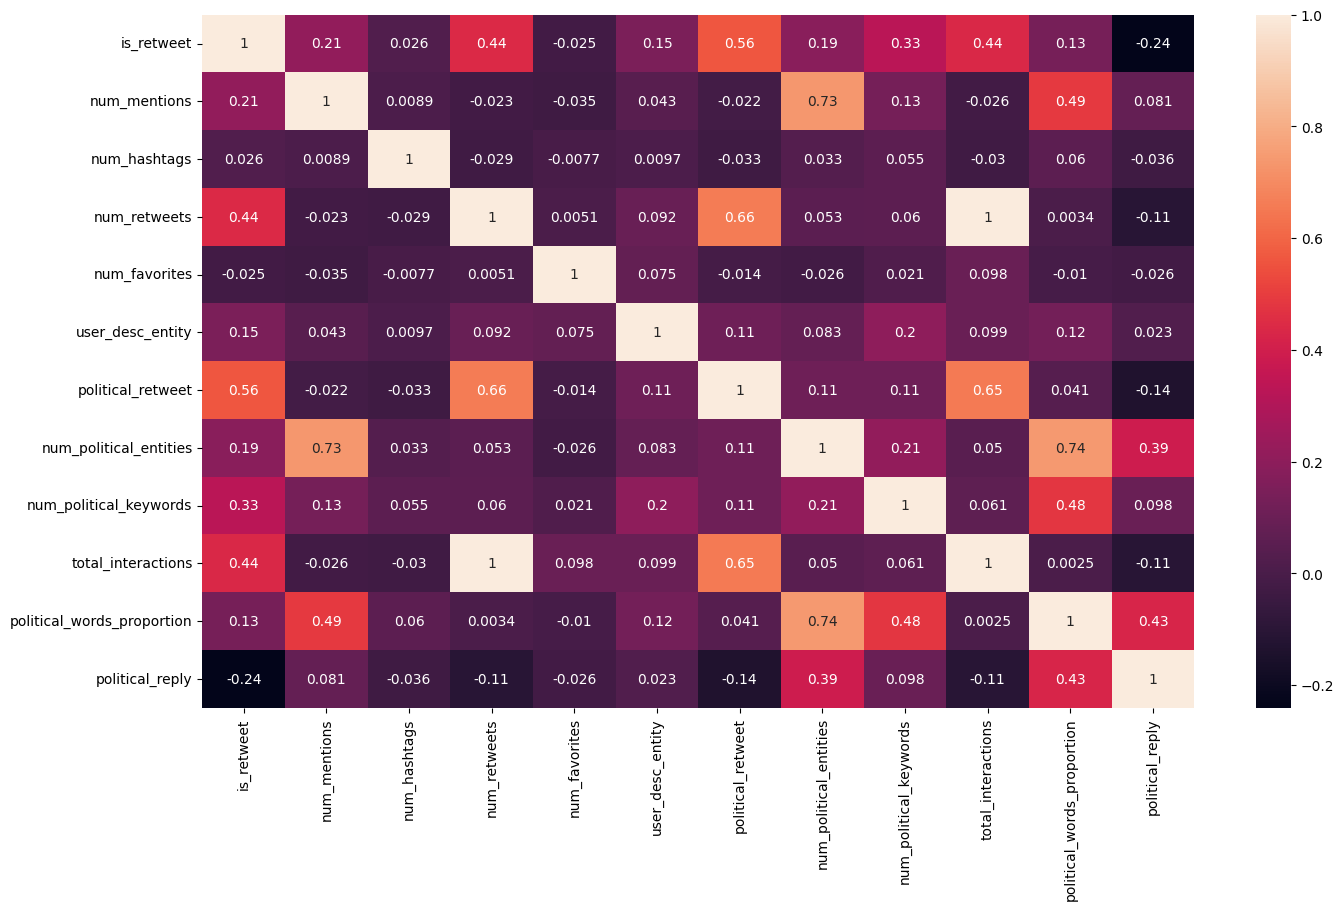

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(dfPoliticalAll_train.drop(['tweet_id', "user_id"], axis = 1).corr(), annot=True)
plt.show()

In [ ]:
dfPoliticalAll_train['isPolitical'].value_counts()

Yes    4123
No     2574
Name: isPolitical, dtype: int64

### 2.1.2. Separate X and y values

In [ ]:
sc = StandardScaler(with_mean = False, with_std = False)

In [ ]:
# Scale the selected features. Features are selected by pre-model training.
dfPoliticalAll_train[["num_retweets","total_interactions","num_political_keywords",
"num_political_entities", "political_words_proportion", "num_hashtags"]] = sc.fit_transform(dfPoliticalAll_train[["num_retweets","total_interactions","num_political_keywords",
                                                            "num_political_entities", "political_words_proportion", "num_hashtags"]])

X_pol_text = dfPoliticalAll_train[["num_retweets", "text", "num_hashtags","total_interactions","num_political_keywords",
"num_political_entities", "political_words_proportion", "annot", "isPolitical"]]

X_pol = dfPoliticalAll_train[["total_interactions","num_political_keywords",
                              "num_political_entities", "political_words_proportion", 
                              "num_retweets", "num_hashtags", "political_reply"]]

y_pol = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

### 2.1.3. Train - Validation - Test split

In [ ]:
rs = 210 #Lucky number.

In [ ]:
'''We checked the model performance with cross validation, so splitting data is just nominal. The code
below is just symbolic, you can split the data when training.'''

X_train_pol, X_test_pol, y_train_pol, y_test_pol = train_test_split(X_pol, y_pol, test_size=0.01, random_state=rs, stratify=y_pol)



### 2.1.4. Train the model

##### 2.1.4.1. XGBoost Instance

In [ ]:
# Baseline Model --> Added hashtags, political_reply lowered baseline MSE, 
# need to retune the parameters
xgb_base = xgb.XGBRegressor(
    objective='binary:logistic',
    random_state = rs
)

In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_base, X_pol, y_pol, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.067164   -0.0684273  -0.07407021 -0.07737583 -0.0685223  -0.06533178
 -0.07690438 -0.05448103 -0.05900761 -0.05330948 -0.05624899 -0.06996952]

Information about Scores:
Cross Validation Score (MSE): 0.06590103616284486
STD of CV Scores: 0.00806664633142424


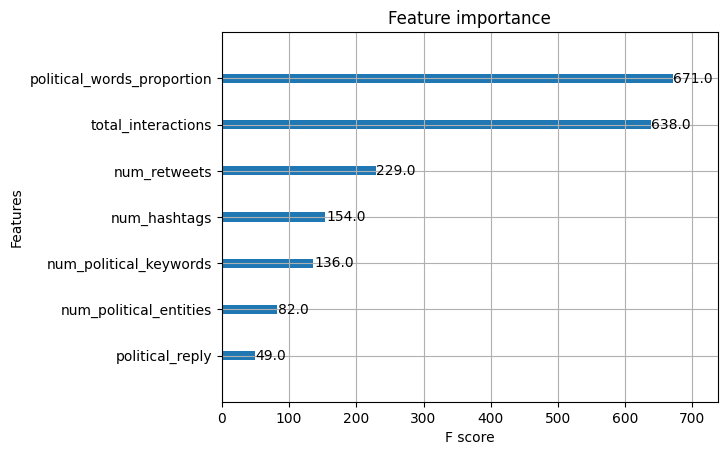

In [ ]:
xgb.plot_importance(xgb_base)
plt.show()

In [ ]:
#Hyperparameter tuning for the model.
params = {
    'max_depth': range(2, 11, 2),
    'min_child_weight':range(1, 6, 2),
    'subsample':[i/10.0 for i in range(5, 11)],
    'colsample_bytree':[i/10.0 for i in range(5, 11)],
    'gamma':[i/10.0 for i in range(6)]
}

tweet_model = GridSearchCV(estimator = xgb_base, param_grid= params, 
                           n_jobs = -1, cv = 5, verbose = 1, 
                           scoring="neg_mean_squared_error")


In [ ]:
print("Best hyperparameters for XGBoost:", tweet_model.best_params_)

Best hyperparameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0}


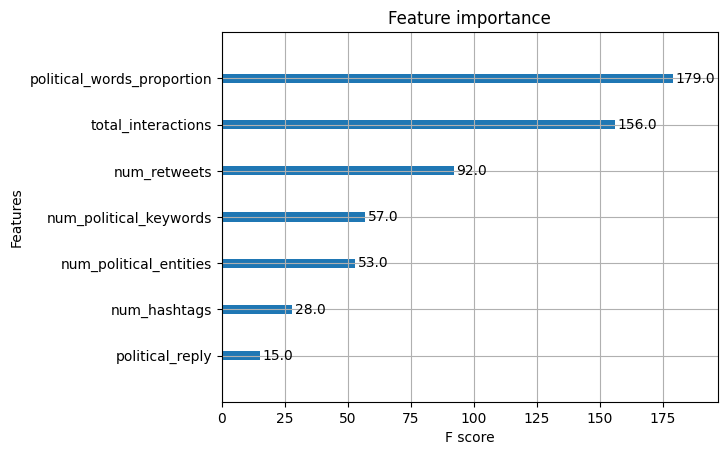

In [ ]:
xgb.plot_importance(tweet_model.best_estimator_)
plt.show()

In [ ]:
# Trial on Optimized Hyperparameters - This parameters came from the GridSearch.

xgb_clf_1 = xgb.XGBRegressor(
    objective='binary:logistic',colsample_bytree= 1, gamma= 0.3, 
    max_depth= 4, min_child_weight= 1, subsample=1, random_state = rs
)



In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_clf_1, X_pol, y_pol, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.0646225  -0.06770056 -0.072933   -0.07359052 -0.06810595 -0.062482
 -0.07477347 -0.05481045 -0.05590166 -0.05356295 -0.05301195 -0.0677569 ]

Information about Scores:
Cross Validation Score (MSE): 0.06410432677323452
STD of CV Scores: 0.00771779828200494


In [ ]:
# Hyperparameter tuning of Ege, these parameters adjusted by hand. 
xgb_clf = xgb.XGBRegressor(
        objective='binary:logistic',colsample_bytree= 0.7, gamma= 0.1, 
        max_depth= 2, min_child_weight= 5, subsample=0.9, random_state = rs
)


In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_clf, X_pol, y_pol, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.06667161 -0.06927368 -0.07470245 -0.07248573 -0.06698971 -0.06215104
 -0.07596801 -0.05623846 -0.05738868 -0.05575877 -0.05791835 -0.07021551]

Information about Scores:
Cross Validation Score (MSE): 0.06548016695048477
STD of CV Scores: 0.007060965445210106


## 2.2. Bot Detection

In [ ]:
'''This is the cleaned version of user dataset, we used this data in training and testing. This is the same 
data as LabeledUsers_Cleaned in GitHub repository. Users are annotated by authorized people.
This dataframe derived from the metadata with the features above.'''
dfBotAll_train_s = pd.read_csv('dfBotAll_train_n.csv', usecols = lambda x: x != 'Unnamed: 0')
screen_names = list(dfBotAll_train_s['user_screen_name'])
dfBotAll_train = dfBotAll_train[dfBotAll_train['user_screen_name'].isin(screen_names)]

In [ ]:
dfBotAll_train['isBot'].value_counts()

No     5631
Yes     878
Name: isBot, dtype: int64

### 2.2.1. Correlation of Features

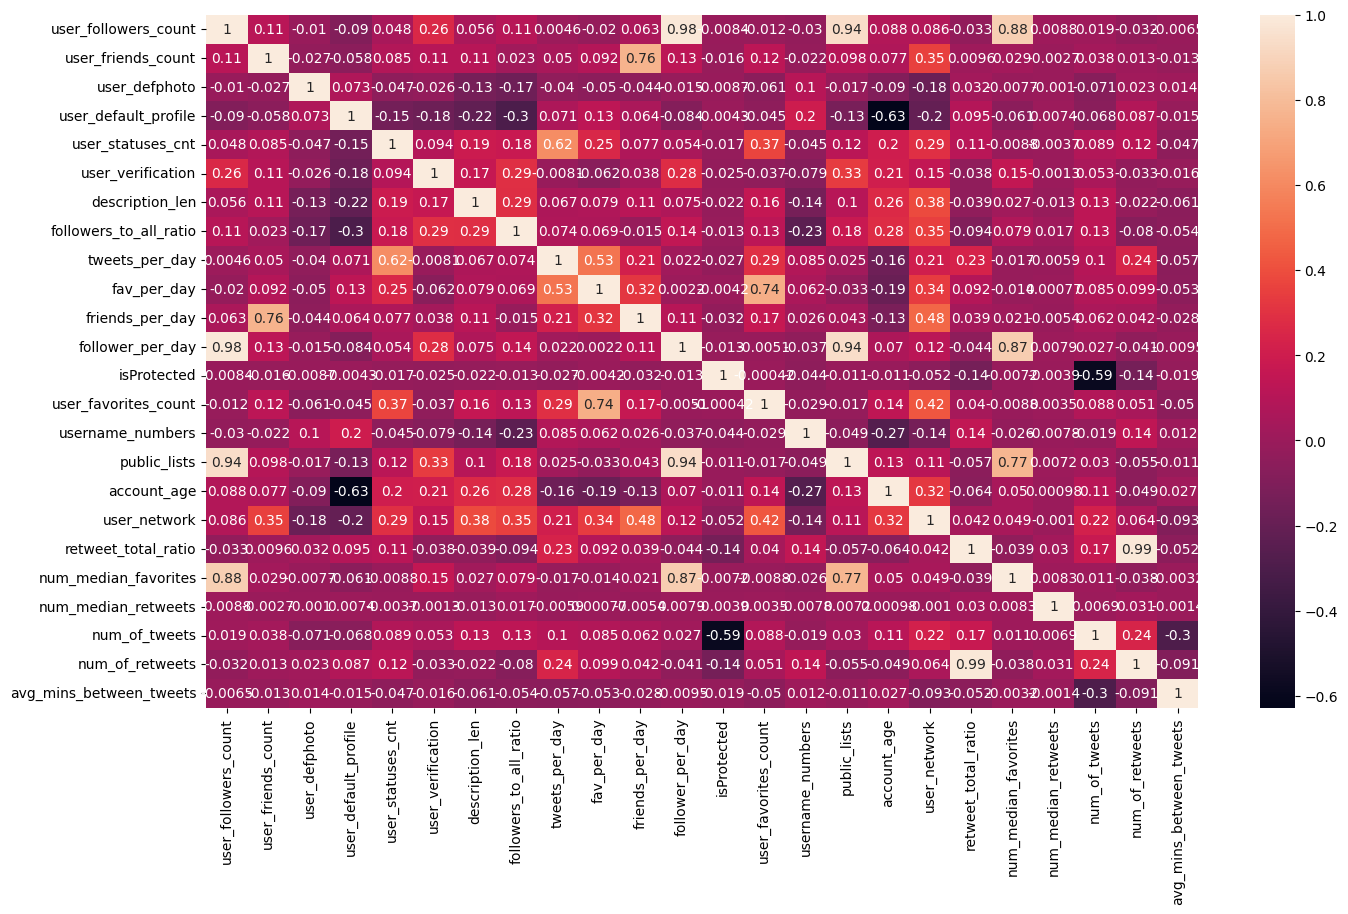

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(dfBotAll_train.drop(['user_id'], axis = 1).corr(), annot=True)
plt.show()

### 2.2.2. Separate X and y values

In [ ]:
dfBotAll_train["user_defphoto"] = dfBotAll_train["user_defphoto"].map({True: 1, False: 0})
dfBotAll_train["user_default_profile"] = dfBotAll_train["user_default_profile"].map({True: 1, False: 0})
dfBotAll_train["user_verification"] = dfBotAll_train["user_verification"].map({True: 1, False: 0})
dfBotAll_train["isProtected"] = dfBotAll_train["isProtected"].map({True: 1, False: 0})

In [ ]:
'''All the features are scaled and features for the model selected by pre-model training.'''
dfBotAll_train[["user_followers_count", "user_friends_count", "user_statuses_cnt", 
                "followers_to_all_ratio","tweets_per_day",  "user_favorites_count", 
                "retweet_total_ratio", "description_len", 'fav_per_day', 'user_network', 
                'follower_per_day','friends_per_day', "username_numbers", "public_lists",
                "account_age", "avg_mins_between_tweets" 
                ]] = sc.fit_transform(dfBotAll_train[[
                "user_followers_count", "user_friends_count", 
                "user_statuses_cnt", "followers_to_all_ratio",
                "tweets_per_day",  "user_favorites_count",
                "retweet_total_ratio", 'description_len' ,'fav_per_day',
                'user_network', 'follower_per_day','friends_per_day', "username_numbers", "public_lists",
                "account_age", "avg_mins_between_tweets" ]])

X_bot = dfBotAll_train[["user_followers_count", "user_friends_count", 
                "user_statuses_cnt", "followers_to_all_ratio",
                "tweets_per_day", "user_favorites_count",
                "retweet_total_ratio", 'description_len' ,'fav_per_day',
                'user_network', 'follower_per_day','friends_per_day',
                "account_age", "avg_mins_between_tweets",
                "user_verification"]]

X_bot_user = dfBotAll_train[["user_screen_name", "isBot", "annot"]]
                    
y_bot = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

/tmp/ipykernel_183/67640005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfBotAll_train[["user_followers_count", "user_friends_count", "user_statuses_cnt",
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


### 2.2.3. Train-test split

In [ ]:
'''We checked the model performance with cross validation, so splitting data is just nominal.
The code is ready for splitting, you can split it if you wish.'''
X_train_bot, X_test_bot, y_train_bot, y_test_bot = train_test_split(X_bot, y_bot, test_size=0.001, random_state=rs, stratify=y_bot)

### 2.2.4. Train the model

In [ ]:
xgb_base_bot = xgb.XGBRegressor(
    objective='binary:logistic', 
    random_state = rs
)


In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_base_bot, X_bot, y_bot, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.0894356  -0.09336096 -0.07371158 -0.09956602 -0.08567288 -0.09761695
 -0.08729789 -0.07482174 -0.07171416 -0.10200534 -0.06406929 -0.09037326]

Information about Scores:
Cross Validation Score (MSE): 0.08580380431395535
STD of CV Scores: 0.011628282760270135


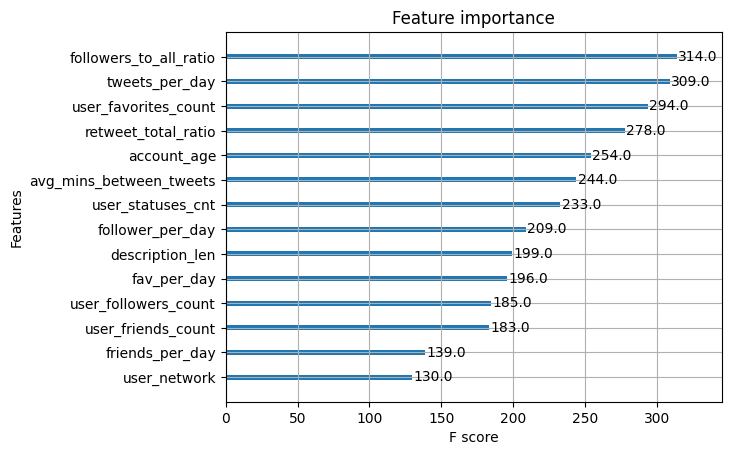

In [ ]:
xgb.plot_importance(xgb_base_bot)
plt.show()

In [ ]:
# Ege's hyperparameter tuning by hand, this parameters adjusted manually.
xgb_bot = xgb.XGBRegressor(
    objective='binary:logistic',colsample_bytree= 0.7, gamma= 0.1, 
    max_depth= 2, min_child_weight= 5, subsample=0.9, random_state = rs
)


In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_bot, X_bot, y_bot, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.07663252 -0.08022458 -0.07031075 -0.09428378 -0.08303517 -0.09152897
 -0.07920072 -0.06803463 -0.06392035 -0.08990151 -0.06407044 -0.07979568]

Information about Scores:
Cross Validation Score (MSE): 0.07841159087815107
STD of CV Scores: 0.009896749412400506


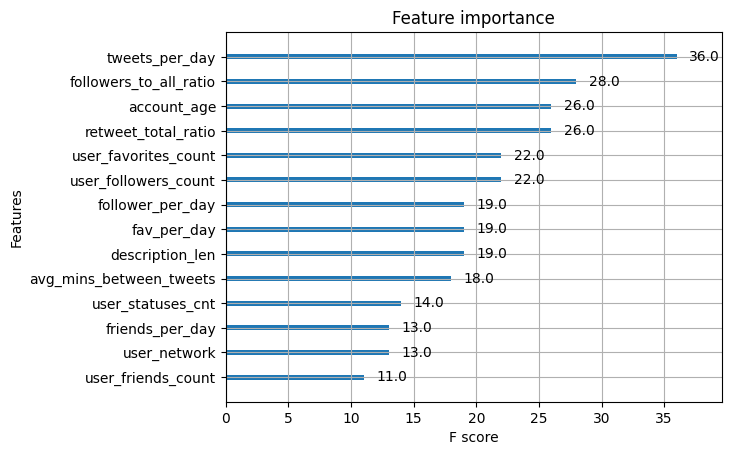

In [ ]:
xgb.plot_importance(xgb_bot)
plt.show()

In [ ]:
# Hyperparameter tuning with GridSearch.
params = {
    'max_depth': range(2, 11, 2),
    'min_child_weight':range(1, 6, 2),
    'subsample':[i/10.0 for i in range(5, 11)],
    'colsample_bytree':[i/10.0 for i in range(5, 11)],
    'gamma':[i/10.0 for i in range(6)]
}

# grid search the model
xgb_bot_model = GridSearchCV(estimator = xgb_base_bot, param_grid= params, 
                           n_jobs = -1, cv = 5, verbose = 1, 
                           scoring="neg_mean_squared_error")


In [ ]:
print("Best parameters for XGBoost:", xgb_bot_model.best_params_)

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.2, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 1.0}


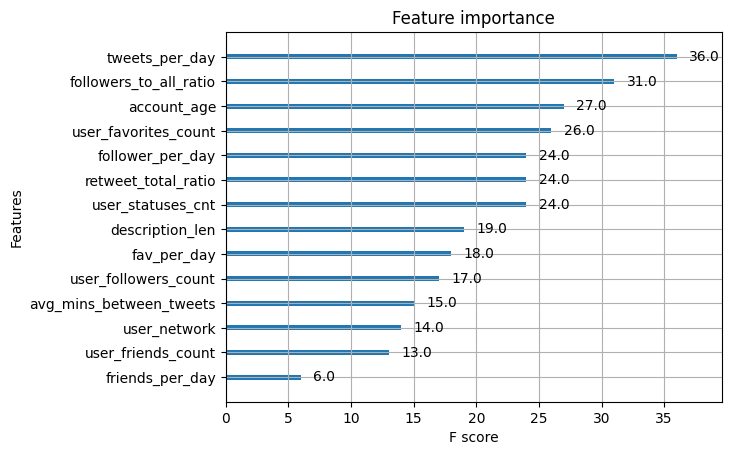

In [ ]:
xgb.plot_importance(xgb_bot_model.best_estimator_)
plt.show()

In [ ]:
# Parameters from GridSearch.
xgb_bot_2 = xgb.XGBRegressor(
    objective='binary:logistic',colsample_bytree= 0.8, gamma= 0.4, 
    max_depth= 2, min_child_weight= 1, subsample=0.8, random_state = rs
)


In [ ]:
# Use cross-validation to evaluate model performance
scores = cross_val_score(xgb_bot_2, X_bot, y_bot, cv=12, scoring='neg_mean_squared_error')

# Print mean and standard deviation of scores
print("Scores:")
print(scores)
print('\nInformation about Scores:')
print("Cross Validation Score (MSE):", np.mean(scores) * -1)
print("STD of CV Scores:", np.std(scores))

Scores:
[-0.07611777 -0.07824593 -0.07056535 -0.09273154 -0.07895111 -0.09524829
 -0.08252911 -0.06497824 -0.06531028 -0.09211751 -0.06596447 -0.08208123]

Information about Scores:
Cross Validation Score (MSE): 0.07873673704352328
STD of CV Scores: 0.010326796229907093


<center><span style="color:#606c38;font-weight:700;font-size:15px;">
Evaluation
    </span></center>

<span><center> Both models were successful on the identified problem, approaching the 0.07~ MSE score. Improvements can be made for future work. Political tweet prediction can be adapted to different countries by changing actors. For bot prediction, the above model is insufficient to make inferences from the user's tweets. In future studies, tweets can be further integrated into the model by analyzing the tweets of bots over tweet text.